In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import itertools, os, sys

sys.path.append('..')
from data.load_data import *
from src.map import *
from src.robot import *
from src.slam import *
from src.utils import *

In [2]:
import pickle

MAP_XLIM = (-15, 15)
MAP_YLIM = (-15, 15)
MAP_RESOLUTION = 0.05

belief = 0.8
MAP_LOGODDS_OCCUPIED_DIFF = np.log(belief/(1-belief))
MAP_LOGODDS_FREE_DIFF = np.log((1-belief)/belief)*.5
MAP_LOGODDS_LIM = (-100, 100)

N_PARTICLES = 128
N_EFF_THRESHOLD = 4
PREDICT_NOISE_SIGMA = np.diag([1e-3, 1e-3, 1e-3])
MAP_LOGODDS_OCCUPIED_THRESHOLD = np.log(9)

SAVE_MAP_FIG_FNAME_TEMPLATE = '../fig/MAP_0/{}.jpg'
# SAVE_MAP_FIG_FNAME_TEMPLATE = None
SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = '../fig/MAP_TEXTURE_0_DISTORT/{}.jpg'

with open('../data/train0.pkl', 'rb') as f:
    datas = pickle.load(f)

In [3]:
from p2_utils import *
from multiprocessing import Pool
import cv2

logodds = Map2D(xlim=MAP_XLIM, ylim=MAP_YLIM, resolution=MAP_RESOLUTION)

state = { 'x': 0, 'y': 0, 'theta': 0 }
for di, data in enumerate(datas):
    for i, key in enumerate(['x', 'y', 'theta']):
        state[key] += data['lidar_delta_pose'][0, i]
        
    if di % 1 == 0:
        lidar_scan = data['lidar_scan']
        lidar_scan_points = np.hstack([data['lidar_scan_points'], np.ones((data['lidar_scan_points'].shape[0], 1))])
        t = Transform(**state, **data)
        lidar_scan_points_w = t.chain('wTb', 'bTh', 'hTl') @ lidar_scan_points.T
        lidar_scan_points_w = lidar_scan_points_w.T[:, :3]
        lidar_scan_points_w = lidar_scan_points_w[lidar_scan_points_w[:, 2] > 0.1, :]
        lidar_scan_points_w = lidar_scan_points_w[logodds.in_map(lidar_scan_points_w), :2]
        
        lidar_scan_indices = logodds.coordinate_to_index(lidar_scan_points_w)
        
        mask = cv2.drawContours(image=np.zeros_like(logodds.data), 
                                contours=[lidar_scan_indices.reshape((-1,1,2)).astype(np.int32)], 
                                contourIdx =-1, 
                                color = MAP_LOGODDS_FREE_DIFF, 
                                thickness=-1)
        logodds.data += mask
        logodds.data[lidar_scan_indices[:, 1], lidar_scan_indices[:, 0]] += MAP_LOGODDS_OCCUPIED_DIFF - MAP_LOGODDS_FREE_DIFF
        logodds.data = np.clip(logodds.data, *MAP_LOGODDS_LIM)
    
    
logodds.data.max()

100.0

1.0 0.0
(601, 601)


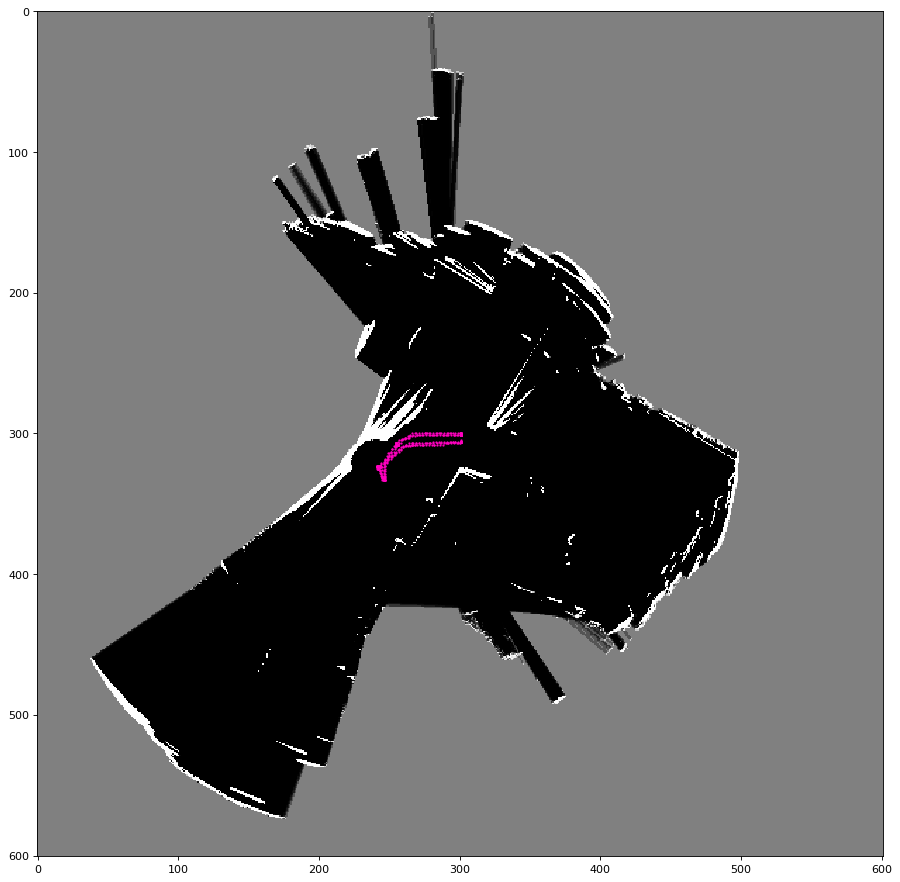

In [4]:
import pylab
from src.util import *

gamma = 1.0 - 1.0/(1.0 + np.exp(logodds.data))
print(gamma.max(), gamma.min())
print(logodds.data.shape)

state = np.array([0, 0, 0], dtype=np.float64)
posx = []
posy = []

for i, data in enumerate(datas):
    state[0] += data['lidar_delta_pose'][0, 0]
    state[1] += data['lidar_delta_pose'][0, 1]
    state[2] += data['lidar_delta_pose'][0, 2]
    
    x, y = logodds.coordinate_to_index([state[0], state[1]]).reshape(-1)
    if i % 20 == 0:
        posx.append(x)
        posy.append(y)

plot_map(gamma, [posx, posy], 20)

In [5]:
%load_ext autoreload
%autoreload 2
from src.slam import ParticleFilterSLAM

slam = ParticleFilterSLAM(
    n_particles=N_PARTICLES,
    n_efficient_threshold=N_EFF_THRESHOLD,
    map_xlim=MAP_XLIM,
    map_ylim=MAP_YLIM,
    map_resolution=MAP_RESOLUTION,
    map_logodds_lim=MAP_LOGODDS_LIM,
    map_logodds_occupied_diff=MAP_LOGODDS_OCCUPIED_DIFF,
    map_logodds_free_diff=MAP_LOGODDS_FREE_DIFF,
    map_logodds_occupied_threshold=MAP_LOGODDS_OCCUPIED_THRESHOLD,
    predict_noise_sigma=PREDICT_NOISE_SIGMA,
    map_texture_undistort_image=False
)

states = [np.array([0, 0, 0])]
for i, data in enumerate(datas):
    with slam.set_robot_data(**data):
        u = slam.predict_particles(data['lidar_delta_pose'][0, :])
        corr, neff = slam.update_particles()

        states.append(slam.robot_state)

        if i % 1 == 0:
            print(i, slam.robot_state, neff, corr.max(), corr.min())
            slam.update_map_logodds()
        
        if i % 10 == 0:
            slam.update_map_texture()
        
        if i % 50 == 0:
            if SAVE_MAP_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(1.0 - slam.map_prob, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
                
            if SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                save_map_fig(slam.map_texture_trimmed, fname,
                             pos=[indices[::5, 0], indices[::5, 1]], npos=np.ceil(len(datas)/5), size=20)
            
        plt.close('all')

0 [-0.06686823 -0.07953169 -0.02187086] 127.99999999999997 0.0 0.0
1 [-0.16388558 -0.2035979  -0.02616379] 127.99999999999997 0.0 0.0
2 [-0.09076732 -0.09725581 -0.02373375] 1.3920451018643638 126.0 5.0
3 [-0.08342895 -0.07695909 -0.02559982] 1.323970272693187 343.0 68.0
4 [-0.07479162 -0.09215177 -0.0191765 ] 1.3065798328092901 557.0 104.0
5 [-0.07972132 -0.08265821 -0.0226331 ] 1.0 740.0 139.0
6 [-0.07344037 -0.08859748 -0.02117661] 1.0000002250703928 736.0 115.0
7 [-0.07229432 -0.09814755 -0.0200855 ] 1.000000000233058 736.0 130.0
8 [-0.07568404 -0.07403587 -0.02323292] 1.0000000000002274 742.0 143.0
9 [-0.06994767 -0.08253659 -0.0258967 ] 1.000000000557975 741.0 135.0
10 [-0.07825805 -0.08856782 -0.02138452] 1.00000003046398 746.0 139.0
11 [-0.07719532 -0.09545225 -0.0193747 ] 1.3783079803215952 740.0 149.0
12 [-0.06543669 -0.09831701 -0.0244953 ] 1.0000907998696575 747.0 131.0
13 [-0.06683142 -0.10266212 -0.02130943] 1.0006709251802495 772.0 152.0
14 [-0.07137436 -0.097187   -0.02

117 [-0.0612242  -0.11392207 -0.02449169] 1.0000090428481778 765.0 150.0
118 [-0.05632996 -0.10823931 -0.02776762] 2.1037233511615616 770.0 115.0
119 [-0.05821669 -0.10851659 -0.02885251] 1.9762194146015153 755.0 141.0
120 [-0.05303857 -0.12235189 -0.02696173] 1.0063366001113694 759.0 120.0
121 [-0.05715344 -0.09809189 -0.02627885] 1.0366315027714619 749.0 127.0
122 [-0.05729516 -0.1188882  -0.02629304] 1.037897394525027 770.0 141.0
123 [-0.06529643 -0.11632402 -0.0237749 ] 1.073978009357546 759.0 134.0
124 [-0.05200699 -0.11104338 -0.02659042] 1.0049575574562921 772.0 150.0
125 [-0.05798432 -0.1110839  -0.02569558] 1.0001242353146043 778.0 135.0
126 [-0.04406477 -0.10614122 -0.02658602] 1.099329209650872 765.0 130.0
127 [-0.0625832  -0.11975054 -0.02705217] 1.6480563789742815 761.0 123.0
128 [-0.05930903 -0.10589699 -0.02403965] 1.0000016630851953 765.0 153.0
129 [-0.04868755 -0.11642826 -0.03065529] 1.6488774776656112 729.0 152.0
130 [-0.07186179 -0.11553471 -0.02513265] 1.3479140949

231 [-0.04636868 -0.1180935  -0.02602327] 1.0 765.0 134.0
232 [-0.0584063  -0.11112845 -0.02771329] 1.0018254285057544 765.0 158.0
233 [-0.05102375 -0.11869008 -0.02753388] 1.0000000041980002 771.0 112.0
234 [-0.04323148 -0.12308079 -0.02764277] 1.0049592240718896 757.0 125.0
235 [-0.05279828 -0.11189105 -0.02379679] 1.0 751.0 151.0
236 [-0.05100293 -0.11300145 -0.02289327] 1.0993281631112202 749.0 133.0
237 [-0.04167606 -0.10708973 -0.02689826] 1.0 760.0 155.0
238 [-0.05338985 -0.12421709 -0.02452956] 2.287654169690554 750.0 132.0
239 [-0.06151121 -0.11121044 -0.0277951 ] 1.0003393768512476 754.0 129.0
240 [-0.05219835 -0.13258317 -0.02448432] 1.10123776003348 737.0 146.0
241 [-0.05582191 -0.11937048 -0.02465522] 1.0099747648554878 765.0 151.0
242 [-0.05847987 -0.12176842 -0.02864375] 1.1376550147162037 752.0 142.0
243 [-0.04685362 -0.10983291 -0.02539122] 1.0000016982258557 764.0 160.0
244 [-0.04642982 -0.11954506 -0.02510232] 1.0000001132586978 766.0 139.0
245 [-0.05553811 -0.109064

345 [-0.05111334 -0.11802899 -0.03013009] 1.001823773640687 731.0 104.0
346 [-0.05558635 -0.10872086 -0.02516505] 1.000012596295804 727.0 115.0
347 [-0.05152252 -0.10707227 -0.02800188] 1.0000000000038654 733.0 150.0
348 [-0.04825924 -0.11789663 -0.02962895] 1.000001674848847 725.0 125.0
349 [-0.04276078 -0.12551676 -0.02837266] 1.0159889394577923 722.0 144.0
350 [-0.05227794 -0.12668995 -0.02754053] 1.0380198284595055 731.0 146.0
351 [-0.05366572 -0.11499894 -0.02543288] 1.0554159615792449 724.0 140.0
352 [-0.04986173 -0.12549604 -0.02513712] 1.0000000009688392 732.0 125.0
353 [-0.06026244 -0.1191747  -0.0287363 ] 2.5041637268683488 715.0 147.0
354 [-0.04342101 -0.12555078 -0.03080165] 1.013579711893552 706.0 145.0
355 [-0.05272428 -0.12340479 -0.02561846] 1.0000003078701287 724.0 146.0
356 [-0.0555342  -0.10728431 -0.02495481] 1.0049636785702354 711.0 133.0
357 [-0.05347624 -0.12090082 -0.02758786] 1.0000334077345547 725.0 127.0
358 [-0.04930305 -0.11120979 -0.02889947] 2.00000061315

459 [-0.05893678 -0.11898947 -0.02752229] 1.0049597555869194 750.0 119.0
460 [-0.04713306 -0.11242996 -0.0258517 ] 1.0002484843839463 757.0 140.0
461 [-0.04966997 -0.11050019 -0.02870778] 1.0000000015268142 759.0 146.0
462 [-0.05375761 -0.11942656 -0.02644929] 1.0006709251820696 758.0 133.0
463 [-0.0483845  -0.11303579 -0.02831678] 1.0 752.0 155.0
464 [-0.04887376 -0.11222054 -0.02971923] 1.1052229841538457 751.0 134.0
465 [-0.05892009 -0.12314454 -0.02613781] 1.2658024797728902 743.0 156.0
466 [-0.04390988 -0.11473061 -0.02664033] 1.0 760.0 166.0
467 [-0.04905657 -0.11664211 -0.02914371] 1.0049574738948914 749.0 136.0
468 [-0.05239895 -0.11356083 -0.02910132] 1.0018572075688321 744.0 135.0
469 [-0.04103372 -0.12869877 -0.02785619] 1.6651969457757079 737.0 156.0
470 [-0.05909277 -0.12679362 -0.02938664] 1.0137237575477946 735.0 142.0
471 [-0.0510835  -0.11306694 -0.03061002] 1.000012318885337 736.0 129.0
472 [-0.04945925 -0.11304701 -0.02696407] 1.0000006118801619 760.0 131.0
473 [-0.0

573 [-0.04011325 -0.11398996 -0.02625761] 1.004959368210263 748.0 142.0
574 [-0.04587878 -0.1145435  -0.02859889] 1.0000018881382273 770.0 144.0
575 [-0.0523479  -0.11461749 -0.02735837] 1.0000000319867017 776.0 136.0
576 [-0.04750307 -0.11269211 -0.02732185] 1.0000006120099925 771.0 128.0
577 [-0.04392817 -0.11752695 -0.02839166] 1.0067858288242537 770.0 134.0
578 [-0.04333102 -0.11870673 -0.02938218] 1.1031490750530606 767.0 154.0
579 [-0.05209462 -0.1132536  -0.02776006] 2.6332785351755246 770.0 138.0
580 [-0.04396299 -0.11124259 -0.02648186] 2.000684834020765 762.0 147.0
581 [-0.05489808 -0.11844395 -0.02766826] 1.1000702459250227 771.0 162.0
582 [-0.05530036 -0.11428552 -0.02889127] 1.0018254275456246 751.0 148.0
583 [-0.05005301 -0.13454883 -0.02707722] 1.0503350868202839 764.0 110.0
584 [-0.06432699 -0.14093132 -0.02768606] 3.0388383641423125 728.0 151.0
585 [-0.05471056 -0.11739605 -0.02851189] 1.0002485133424033 768.0 141.0
586 [-0.05316223 -0.12252976 -0.03013246] 1.099329991

685 [-0.05030729 -0.12620325 -0.02731988] 1.014150707167933 770.0 106.0
686 [-0.04554231 -0.1172677  -0.02826276] 1.6480691178079243 771.0 116.0
687 [-0.04370644 -0.13440561 -0.02750663] 1.0000907998594248 756.0 152.0
688 [-0.05018337 -0.10842165 -0.02649549] 1.1052229731100258 758.0 121.0
689 [-0.04635938 -0.10939544 -0.02793924] 1.266550259612223 768.0 160.0
690 [-0.05278817 -0.11465879 -0.02585174] 1.013566691234432 764.0 140.0
Updating map texture......
691 [-0.04339765 -0.10887426 -0.02738573] 2.000761908116562 758.0 135.0
692 [-0.05391127 -0.10920777 -0.02784253] 1.0135089094016958 759.0 142.0
693 [-0.03857873 -0.11157867 -0.02865966] 1.000000084315163 756.0 139.0
694 [-0.04114871 -0.10795795 -0.02981168] 1.036623618201394 753.0 129.0
695 [-0.04067689 -0.12103699 -0.02821646] 1.2668273390212876 767.0 146.0
696 [-0.05905638 -0.12675781 -0.02708553] 1.0000122884253024 762.0 138.0
697 [-0.05256263 -0.13080344 -0.02817222] 1.0398554419719654 765.0 143.0
698 [-0.04850057 -0.13961001 -

795 [-0.04784145 -0.12684048 -0.02820679] 1.0050501769420968 763.0 152.0
796 [-0.04322435 -0.11896729 -0.02690181] 1.004991269081433 762.0 134.0
797 [-0.05762877 -0.12275225 -0.0296859 ] 1.2665502302647387 745.0 131.0
798 [-0.04602234 -0.1366263  -0.02944765] 1.0134753144881394 752.0 138.0
799 [-0.05798896 -0.1298955  -0.02712763] 1.0000090434025202 757.0 162.0
800 [-0.05911216 -0.12692792 -0.02658339] 1.0018366750074885 747.0 166.0
Updating map texture......
801 [-0.05873839 -0.11577181 -0.02648719] 1.038510163915311 746.0 157.0
802 [-0.05027592 -0.11881675 -0.02746954] 1.0003376363077312 758.0 143.0
803 [-0.05938466 -0.12632621 -0.02485185] 1.000004521292222 742.0 135.0
804 [-0.04499881 -0.1322411  -0.02843604] 1.0137237646792823 754.0 145.0
805 [-0.0564484  -0.13420493 -0.02725248] 1.0000139558315404 748.0 163.0
806 [-0.051796   -0.13357228 -0.02647047] 1.000313639359802 753.0 156.0
807 [-0.04900361 -0.11079071 -0.02672629] 1.0002468201661772 746.0 144.0
808 [-0.0567132  -0.13474544

905 [-0.05556212 -0.12643577 -0.02929676] 1.6480945187440912 757.0 148.0
906 [-0.05688985 -0.13730911 -0.02716122] 1.0995946230462965 748.0 164.0
907 [-0.04017174 -0.12553157 -0.03124602] 1.269870104451385 750.0 141.0
908 [-0.04768826 -0.13561169 -0.02629071] 1.1045189787814707 759.0 132.0
909 [-0.04619893 -0.13796773 -0.02875702] 1.0000123188848824 762.0 118.0
910 [-0.05139081 -0.12459542 -0.02933978] 1.0019150970938366 766.0 148.0
Updating map texture......
911 [-0.05926644 -0.11275498 -0.02912047] 1.0134800597908549 737.0 132.0
912 [-0.04176193 -0.13243283 -0.02441768] 1.0052094474639373 737.0 145.0
913 [-0.04616881 -0.12323137 -0.02793579] 1.0000910021228244 766.0 149.0
914 [-0.0469383  -0.11330683 -0.02840548] 1.013475328315548 769.0 148.0
915 [-0.04314591 -0.13088961 -0.02749253] 1.0002474330013285 764.0 146.0
916 [-0.04755365 -0.11034847 -0.02944542] 1.0002469031780548 765.0 162.0
917 [-0.05174271 -0.11892465 -0.02793906] 1.6480542743428324 773.0 134.0
918 [-0.0374929  -0.116958

1015 [-0.04575937 -0.12116038 -0.02609249] 1.000251340896588 762.0 146.0
1016 [-0.04718328 -0.12942679 -0.02774711] 1.6480544005266975 770.0 151.0
1017 [-0.05329164 -0.12571671 -0.02645387] 1.0006709253857056 761.0 138.0
1018 [-0.05013463 -0.1140658  -0.02853857] 1.0000000304914922 758.0 145.0
1019 [-0.05295096 -0.13682529 -0.02740281] 1.0993279398210212 751.0 140.0
1020 [-0.04833605 -0.12279585 -0.02931564] 1.2658040830129509 755.0 162.0
Updating map texture......
1021 [-0.05038255 -0.1224743  -0.02809509] 1.000000030491947 764.0 139.0
1022 [-0.0434292  -0.12427931 -0.02865558] 1.0006734259519963 766.0 134.0
1023 [-0.04511603 -0.13621389 -0.03018973] 1.4906296081228179 757.0 166.0
1024 [-0.04319607 -0.13031455 -0.03019446] 1.0000334034131737 765.0 156.0
1025 [-0.04989647 -0.13561241 -0.02909048] 1.0368702799089426 768.0 146.0
1026 [-0.04734051 -0.12251283 -0.03047556] 1.000000010609938 767.0 112.0
1027 [-0.04946846 -0.11160004 -0.02844856] 1.0000000001032276 767.0 143.0
1028 [-0.05719

1123 [-0.05558549 -0.1283983  -0.0285095 ] 1.0018239877669886 764.0 149.0
1124 [-0.0488249  -0.12586541 -0.02809059] 1.0134752937084284 767.0 143.0
1125 [-0.04210011 -0.1171335  -0.02728554] 1.0203063171416535 755.0 133.0
1126 [-0.03969619 -0.12777143 -0.03134124] 1.0006709251909434 754.0 140.0
1127 [-0.0348957  -0.12319406 -0.03053899] 1.0367121324519664 744.0 125.0
1128 [-0.04546311 -0.13548324 -0.03103515] 1.2658028237008827 755.0 135.0
1129 [-0.05573515 -0.13221461 -0.02750476] 1.0366189935506605 763.0 171.0
1130 [-0.03982435 -0.12570393 -0.02904988] 1.0000000153424937 763.0 157.0
Updating map texture......
1131 [-0.0494699  -0.14555364 -0.03113807] 2.3907517547478405 732.0 134.0
1132 [-0.05264934 -0.12979777 -0.02714623] 1.0006711510894597 760.0 133.0
1133 [-0.03465439 -0.13214051 -0.02816436] 1.0000006463868674 751.0 132.0
1134 [-0.05464902 -0.12677929 -0.02886733] 1.099328014742753 763.0 152.0
1135 [-0.0409059  -0.11773015 -0.0276001 ] 1.0000380181425144 757.0 140.0
1136 [-0.052

1231 [-0.05159903 -0.12656572 -0.02876712] 1.0366207712625877 759.0 120.0
1232 [-0.03889501 -0.13011609 -0.02518114] 1.266077407716038 727.0 146.0
1233 [-0.04373204 -0.12498695 -0.03132855] 1.0000000114862362 750.0 163.0
1234 [-0.04447816 -0.13578874 -0.02814883] 1.0006802045215997 747.0 155.0
1235 [-0.0549003  -0.13299752 -0.0273837 ] 1.001857283259734 751.0 156.0
1236 [-0.04405401 -0.11858526 -0.03145992] 2.000024576939517 745.0 147.0
1237 [-0.05409679 -0.13106242 -0.03048225] 1.0993407957476873 751.0 146.0
1238 [-0.0454612  -0.13351602 -0.02698068] 1.0000000305494725 752.0 156.0
1239 [-0.04051201 -0.13116595 -0.02990654] 1.0052049981713718 756.0 136.0
1240 [-0.04729239 -0.12386761 -0.02767235] 1.0000000304598873 761.0 137.0
Updating map texture......
1241 [-0.05120572 -0.12590979 -0.02759186] 1.000016893428678 762.0 150.0
1242 [-0.03197496 -0.12938628 -0.02963395] 2.7342560085795644 732.0 124.0
1243 [-0.044399   -0.11980298 -0.02723534] 1.3073415486029947 751.0 148.0
1244 [-0.051754

1339 [-0.05194324 -0.14256028 -0.0280434 ] 1.0000123109394388 752.0 133.0
1340 [-0.05305137 -0.12355547 -0.02794176] 1.0417626297989713 772.0 163.0
Updating map texture......
1341 [-0.04471256 -0.12965502 -0.02745133] 1.0406946236662207 766.0 152.0
1342 [-0.04979757 -0.12808612 -0.02892097] 1.0006709252662545 772.0 144.0
1343 [-0.0434189  -0.12925904 -0.03209377] 1.203198508606621 754.0 153.0
1344 [-0.05650973 -0.13398138 -0.02876525] 1.000259113771475 761.0 116.0
1345 [-0.04482314 -0.11843362 -0.03157078] 1.2808141968313969 759.0 149.0
1346 [-0.05248428 -0.13459278 -0.02644873] 1.000247667789774 758.0 139.0
1347 [-0.03841039 -0.12111146 -0.02917742] 1.0007662819956749 756.0 166.0
1348 [-0.04257181 -0.13213502 -0.03002181] 1.099328688317354 763.0 175.0
1349 [-0.05114189 -0.12177105 -0.03014441] 1.0044125880827162 758.0 164.0
1350 [-0.04956663 -0.12213067 -0.03260008] 1.0993281803915862 745.0 110.0
Updating map texture......
1351 [-0.0422658  -0.11470858 -0.02737915] 1.005452363972889 7

1447 [ 0.00861229 -0.15605469 -0.03256912] 1.4506957271717318 588.0 159.0
1448 [-0.00174928 -0.14637804 -0.0363476 ] 1.0376457914206956 602.0 121.0
1449 [ 0.01612473 -0.14810604 -0.03639233] 1.6664713565599412 596.0 139.0
1450 [ 0.00571747 -0.14323755 -0.03807062] 1.648862574832128 596.0 144.0
Updating map texture......
1451 [ 0.01857219 -0.14511916 -0.03574454] 1.301514762736028 597.0 153.0
1452 [ 0.00785127 -0.16020773 -0.03221919] 2.087017984766988 595.0 125.0
1453 [ 0.00444483 -0.1521574  -0.03472384] 1.2658078654829137 607.0 131.0
1454 [ 0.00175179 -0.15724083 -0.03463332] 1.648054274336087 602.0 137.0
1455 [-0.00182637 -0.15326818 -0.03426461] 1.0000002272590924 595.0 131.0
1456 [ 0.01154052 -0.15866048 -0.03465367] 1.002005564471038 606.0 133.0
1457 [ 0.00512655 -0.13551137 -0.0327921 ] 1.203405533358379 591.0 140.0
1458 [ 0.00271762 -0.15352519 -0.03470351] 1.0018241016103975 603.0 115.0
1459 [ 0.00979076 -0.15358701 -0.03417939] 1.0758078164075155 604.0 133.0
1460 [ 0.00794902

1555 [ 0.02639598 -0.14221834 -0.03438476] 2.098305993096247 643.0 159.0
1556 [ 0.03584875 -0.14340992 -0.03820512] 1.2733674440161071 645.0 141.0
1557 [ 0.02186343 -0.14525862 -0.03427572] 1.6919996232542767 646.0 143.0
1558 [ 0.03936143 -0.14778106 -0.03715811] 1.0153451533424138 644.0 153.0
1559 [ 0.03598915 -0.14537511 -0.03521241] 1.6981833671032212 651.0 190.0
1560 [ 0.04810656 -0.15000292 -0.03427352] 1.7084045013611002 643.0 158.0
Updating map texture......
1561 [ 0.03359012 -0.152444   -0.03534366] 2.31066939246404 649.0 175.0
1562 [ 0.02578748 -0.16204897 -0.03148596] 1.9652404867273237 622.0 157.0
1563 [ 0.03257342 -0.15902611 -0.03748092] 1.1001256226216316 636.0 157.0
1564 [ 0.0359579  -0.14783677 -0.03585017] 1.0002468237393267 653.0 148.0
1565 [ 0.04474446 -0.1512806  -0.03630098] 2.718861398801413 649.0 168.0
1566 [ 0.03895164 -0.15423727 -0.03970239] 3.3167027995692058 641.0 152.0
1567 [ 0.03318198 -0.15404603 -0.0361581 ] 2.105154795295995 657.0 161.0
1568 [ 0.0428659

1663 [ 0.00517396 -0.1580372  -0.03867   ] 2.3628493387255016 674.0 188.0
1664 [ 0.01936665 -0.15443714 -0.03759653] 1.321789508207536 692.0 149.0
1665 [ 0.02723438 -0.14713505 -0.03983634] 1.0000953207235455 686.0 174.0
1666 [ 0.00895813 -0.14370202 -0.0407333 ] 1.013609647644041 677.0 166.0
1667 [ 0.01803133 -0.15848323 -0.03782381] 1.0019269494007927 689.0 156.0
1668 [ 0.02714712 -0.14788852 -0.03740672] 1.0001030888458933 700.0 149.0
1669 [ 0.01997241 -0.15871359 -0.03797347] 1.6584435894774343 695.0 159.0
1670 [ 0.02364046 -0.14995405 -0.0387256 ] 1.0270418181406347 696.0 172.0
Updating map texture......
1671 [ 0.00984526 -0.14458203 -0.03736597] 1.0074634757469907 693.0 171.0
1672 [ 0.00424813 -0.15131473 -0.0393914 ] 2.093999087761375 691.0 141.0
1673 [ 0.0247842  -0.14169157 -0.03952725] 2.3739079301775794 701.0 166.0
1674 [ 0.0099244  -0.14503316 -0.03715272] 1.0134770027093207 690.0 153.0
1675 [ 0.02044927 -0.14291781 -0.03933737] 1.265816021915561 699.0 132.0
1676 [ 0.012307

1771 [ 0.0287519  -0.15151004 -0.03460451] 1.95902115545372 711.0 169.0
1772 [ 0.01831739 -0.14308608 -0.03607772] 1.0019208458441742 711.0 149.0
1773 [ 0.00859112 -0.14511814 -0.03810112] 1.6483625334826415 730.0 156.0
1774 [ 0.02029656 -0.14680358 -0.03953102] 1.000000000027967 744.0 199.0
1775 [ 0.02693142 -0.15874193 -0.03998535] 1.2658023212318226 730.0 180.0
1776 [ 0.02917941 -0.13849322 -0.03942798] 1.0134769870727205 729.0 162.0
1777 [ 0.01672111 -0.14782187 -0.04156882] 1.0009529103238817 736.0 168.0
1778 [ 0.01703692 -0.14746851 -0.0412423 ] 1.0368704783232245 736.0 182.0
1779 [ 0.03208943 -0.15177167 -0.03963869] 1.0140059030200805 731.0 179.0
1780 [ 0.01804881 -0.14786351 -0.03944464] 1.000670967012312 734.0 197.0
Updating map texture......
1781 [ 0.00947644 -0.14679676 -0.03933088] 1.0000908303311737 737.0 175.0
1782 [ 0.01789957 -0.15274014 -0.04151416] 1.648055313919252 728.0 160.0
1783 [ 0.01517369 -0.13997998 -0.03802051] 2.0367925133136113 730.0 173.0
1784 [ 0.0325733

1879 [ 0.02279885 -0.152577   -0.04040455] 1.000000012749979 749.0 182.0
1880 [ 0.02057375 -0.14088191 -0.03867137] 1.0134769611201038 746.0 175.0
Updating map texture......
1881 [ 0.02203203 -0.1413261  -0.04030096] 1.0000002555305143 739.0 205.0
1882 [ 0.02420278 -0.14525567 -0.03796344] 1.0000000000104592 741.0 168.0
1883 [ 0.01786905 -0.15367015 -0.04012025] 1.000066807371162 739.0 185.0
1884 [ 0.04989621 -0.15321109 -0.03961979] 1.0391809231329663 711.0 198.0
1885 [ 0.0174394  -0.15167006 -0.04116193] 1.0000000000052296 758.0 186.0
1886 [ 0.0186059  -0.15016337 -0.03929118] 1.0002759435291784 747.0 162.0
1887 [ 0.025806   -0.14333404 -0.04044333] 1.6480542736638317 748.0 184.0
1888 [ 0.02976744 -0.14855699 -0.03960121] 1.0000000000002274 753.0 179.0
1889 [ 0.01189078 -0.14964711 -0.0376154 ] 1.0366529978589827 735.0 153.0
1890 [ 0.02210133 -0.15026069 -0.04077426] 1.3766827940199746 757.0 154.0
Updating map texture......
1891 [ 0.03218009 -0.14444724 -0.04025019] 1.000337630681972

1987 [ 0.02600247 -0.1423167  -0.03882141] 1.0000908000206472 746.0 183.0
1988 [ 0.02316068 -0.14310101 -0.03913367] 1.0000065235806253 745.0 187.0
1989 [ 0.05153461 -0.15517316 -0.03992704] 1.0004936697284594 727.0 174.0
1990 [ 0.02653205 -0.14661709 -0.04335226] 1.1000305098788323 756.0 201.0
Updating map texture......
1991 [ 0.02231424 -0.15271577 -0.0416846 ] 1.0006725930239515 753.0 170.0
1992 [ 0.01840271 -0.1538776  -0.04199394] 1.0000910249677633 756.0 149.0
1993 [ 0.04581659 -0.15280785 -0.04072792] 1.0000045208683956 743.0 161.0
1994 [ 0.03578001 -0.15560203 -0.04008942] 1.0368702489733805 747.0 181.0
1995 [ 0.01933444 -0.14276009 -0.04033228] 1.0000006230139757 748.0 166.0
1996 [ 0.02369407 -0.14597294 -0.04394244] 1.2658159300061493 744.0 164.0
1997 [ 0.02818908 -0.16043917 -0.04075617] 1.000000000075488 745.0 176.0
1998 [ 0.02324696 -0.14433198 -0.03925864] 1.0050530612720703 753.0 184.0
1999 [ 0.02353507 -0.14356781 -0.04318165] 1.0741788959639507 743.0 177.0
2000 [ 0.044

2095 [ 0.01847253 -0.1516062  -0.03849633] 1.0000000114312118 749.0 195.0
2096 [ 0.04352131 -0.15668986 -0.04348833] 1.0000045319435902 726.0 173.0
2097 [ 0.02489951 -0.14420919 -0.04065973] 1.0000004531774132 750.0 169.0
2098 [ 0.02293387 -0.15084049 -0.04146833] 1.0000000041325166 745.0 222.0
2099 [ 0.01343554 -0.15193965 -0.04264754] 1.027052600351665 742.0 229.0
2100 [ 0.02718123 -0.15529288 -0.04342186] 1.0000023055318332 746.0 188.0
Updating map texture......
2101 [ 0.02400664 -0.15244919 -0.03847137] 1.000675447421543 743.0 154.0
2102 [ 0.02229001 -0.14591844 -0.0402654 ] 1.0000006120102198 752.0 209.0
2103 [ 0.02183077 -0.15571371 -0.04135802] 1.1153582905963757 757.0 162.0
2104 [ 0.02881041 -0.15783039 -0.04156411] 1.0137237575510218 738.0 159.0
2105 [ 0.02940942 -0.16068258 -0.04099473] 2.6257669669144854 736.0 187.0
2106 [ 0.03012113 -0.15215298 -0.04148622] 1.7663713924183386 754.0 173.0
2107 [ 0.01374821 -0.14663621 -0.04023314] 1.1045187511055863 739.0 161.0
2108 [ 0.0326

2203 [ 0.03309455 -0.14866759 -0.04488048] 1.0007957836568264 743.0 166.0
2204 [ 0.03144261 -0.14642501 -0.04268509] 1.0049574738935203 752.0 165.0
2205 [ 0.01835152 -0.15906919 -0.0409634 ] 1.0155599347013113 733.0 152.0
2206 [ 0.02749638 -0.16124342 -0.03981216] 1.0159872716233136 735.0 183.0
2207 [ 0.02579404 -0.15494466 -0.04014512] 1.0134810650207222 754.0 167.0
2208 [ 0.02675536 -0.1468519  -0.04129247] 1.000000613401975 753.0 131.0
2209 [ 0.01489054 -0.15559647 -0.04311154] 1.000012374256966 739.0 165.0
2210 [ 0.02792852 -0.1530691  -0.04292633] 1.2808521503375754 749.0 167.0
Updating map texture......
2211 [ 0.03736001 -0.14982175 -0.04245652] 1.2658024797682852 749.0 179.0
2212 [ 0.01160615 -0.15465809 -0.04247489] 1.3073197545950819 732.0 175.0
2213 [ 0.02166641 -0.15170855 -0.0426429 ] 1.000000000557975 754.0 166.0
2214 [ 0.03378834 -0.1477734  -0.04418257] 1.0000145959193085 741.0 162.0
2215 [ 0.02897555 -0.14548662 -0.04035319] 1.6802998717596265 753.0 164.0
2216 [ 0.01577

2311 [ 0.04876224 -0.22342172 -0.04968725] 1.0006834546412664 675.0 203.0
2312 [ 0.05007077 -0.22171066 -0.04526571] 1.0993629116859303 694.0 179.0
2313 [ 0.0540647  -0.20521574 -0.04702497] 1.0018237626202864 689.0 188.0
2314 [ 0.03725    -0.20816796 -0.03947331] 1.102752707443272 703.0 168.0
2315 [ 0.03447138 -0.20108419 -0.03751035] 1.1437346794313423 705.0 180.0
2316 [ 0.03533576 -0.18780384 -0.04068118] 1.6502723868079103 707.0 137.0
2317 [ 0.03826292 -0.19345525 -0.03959657] 1.0373408525638426 704.0 149.0
2318 [ 0.02133838 -0.1726805  -0.04111694] 1.1136949816015067 707.0 163.0
2319 [ 0.02515687 -0.16971902 -0.04300474] 1.0004937420956008 724.0 189.0
2320 [ 0.01261789 -0.16565799 -0.04011124] 2.1006696414705504 710.0 168.0
Updating map texture......
2321 [ 0.00503176 -0.14139717 -0.03894078] 1.014150796261447 709.0 178.0
2322 [ 0.03327157 -0.14876014 -0.04131476] 1.0367239683709306 692.0 198.0
2323 [ 0.00959103 -0.13580787 -0.03928252] 1.6540248674147302 686.0 198.0
2324 [ 0.0264

2419 [ 0.04917862 -0.14737851 -0.04148273] 1.6642641413707513 729.0 177.0
2420 [ 0.03236848 -0.15233627 -0.04214867] 1.1376597328689049 708.0 165.0
Updating map texture......
2421 [ 0.04356044 -0.16733751 -0.03919433] 1.3069764804154613 706.0 200.0
2422 [ 0.03438226 -0.15903432 -0.03276611] 2.0061449017782165 691.0 169.0
2423 [ 0.02584038 -0.16777452 -0.02827907] 1.002072417502793 698.0 179.0
2424 [ 0.0253555  -0.16303451 -0.02840242] 1.0996237656476338 699.0 145.0
2425 [ 0.0354226  -0.17860823 -0.03128368] 1.6603023365103462 713.0 164.0
2426 [ 0.01843391 -0.18035043 -0.03805818] 1.1045207294686061 727.0 144.0
2427 [ 0.01804841 -0.1924715  -0.03734815] 1.0292556719051933 711.0 203.0
2428 [ 0.01461796 -0.18484159 -0.04123665] 1.000247432088652 727.0 177.0
2429 [ 0.01817913 -0.19901789 -0.04404098] 1.0366190366769021 726.0 161.0
2430 [ 0.02528942 -0.19099714 -0.04324805] 1.648864598014086 715.0 188.0
Updating map texture......
2431 [ 0.01307153 -0.18888536 -0.04355551] 1.6480546849498554

2527 [ 0.1070397  -0.08446459  0.00495297] 2.0239534375138595 647.0 146.0
2528 [ 0.11340863 -0.06934517  0.00620551] 1.2811947258065035 657.0 183.0
2529 [ 0.1072024  -0.07514157  0.00618805] 2.0436813660062745 677.0 148.0
2530 [ 0.11163293 -0.06772565  0.00245435] 1.0003850766086444 669.0 146.0
Updating map texture......
2531 [ 0.12051692 -0.09563429 -0.00165734] 2.0000340959159724 675.0 186.0
2532 [ 0.11070746 -0.10345898 -0.01104278] 1.0103577515124342 685.0 177.0
2533 [ 0.12546092 -0.1144134  -0.01524056] 2.0019148498343227 686.0 187.0
2534 [ 0.11781863 -0.12534121 -0.01310377] 1.1015046009360379 681.0 188.0
2535 [ 0.11151166 -0.12836011 -0.01592448] 1.0000213370956694 695.0 182.0
2536 [ 0.10093781 -0.12921921 -0.02022875] 1.0027469568942733 691.0 217.0
2537 [ 0.11802188 -0.14477308 -0.01730102] 1.0000398997086284 698.0 195.0
2538 [ 0.09075749 -0.13109281 -0.01594083] 1.000766282095796 701.0 187.0
2539 [ 0.11210887 -0.13772904 -0.01245824] 1.0002469065362831 707.0 212.0
2540 [ 0.105

2635 [ 0.17229652 -0.16795816 -0.00102969] 1.1379178021225886 726.0 164.0
2636 [ 0.17315596 -0.17614901 -0.00133976] 1.2658394849005088 717.0 160.0
2637 [ 0.18879326 -0.16894752 -0.00164422] 1.0000356784198414 707.0 200.0
2638 [ 0.17603485 -0.15763765 -0.00208154] 1.3066448715871204 715.0 178.0
2639 [ 0.19547254 -0.15219196  0.00126306] 1.0050502599456137 721.0 202.0
2640 [ 0.20017253 -0.14941407 -0.00079986] 1.0134759927571708 724.0 168.0
Updating map texture......
2641 [ 0.1921866  -0.14198389  0.00025046] 1.00000003066657 716.0 187.0
2642 [ 0.21214742 -0.13704455  0.00175765] 1.0996914331637033 720.0 186.0
2643 [ 0.20758466 -0.13342263  0.00174376] 1.006787422095762 719.0 173.0
2644 [ 0.21304527 -0.11422303 -0.00184622] 1.0382385557736873 711.0 162.0
2645 [ 0.2066381  -0.10730404  0.00311705] 1.006790609178937 713.0 177.0
2646 [ 0.21964356 -0.10020802  0.0012945 ] 1.0007045997607662 710.0 174.0
2647 [ 0.21164348 -0.08921625 -0.00323054] 1.0373368525081939 713.0 160.0
2648 [ 0.209693

2743 [ 0.33139746 -0.14521715  0.00306592] 1.000004757726231 731.0 172.0
2744 [ 0.33287127 -0.14219549  0.0024975 ] 2.1032843101202996 728.0 152.0
2745 [ 0.34047334 -0.15938024  0.00383067] 1.0000017458845956 731.0 173.0
2746 [ 0.34192215 -0.17053206  0.01100113] 1.0002476581096718 730.0 157.0
2747 [ 0.34064524 -0.18065071  0.01127034] 1.0369097243373064 736.0 142.0
2748 [ 0.33426241 -0.17120361  0.01515148] 1.1384662823534641 727.0 158.0
2749 [ 0.33610985 -0.18871972  0.01158028] 1.2723542975453834 724.0 172.0
2750 [ 0.34845319 -0.19000017  0.00896296] 1.000000842524308 732.0 167.0
Updating map texture......
2751 [ 0.35745751 -0.19046087  0.00623899] 1.10719120242665 721.0 163.0
2752 [ 0.35096046 -0.18988721  0.00445079] 1.0366575994716951 721.0 170.0
2753 [ 0.34525535 -0.2073491   0.00236733] 1.1134479180929473 717.0 149.0
2754 [ 0.35732123 -0.20005091  0.0014352 ] 1.0018572791286544 729.0 149.0
2755 [ 0.35099424 -0.19552871 -0.00159153] 1.0000475807613212 721.0 183.0
2756 [ 3.602980

2851 [ 0.52708858 -0.05629318  0.03634783] 1.6642638104850636 707.0 173.0
2852 [ 0.5168091  -0.05494315  0.04072319] 2.4392967635956184 711.0 132.0
2853 [ 0.53083705 -0.05873129  0.03915733] 1.0018383395700012 710.0 137.0
2854 [ 0.54050859 -0.07167707  0.0344929 ] 1.0135666897180158 708.0 149.0
2855 [ 0.53625556 -0.09757906  0.03001172] 1.036722365290219 709.0 173.0
2856 [ 0.53261125 -0.08611655  0.02770968] 1.03802178903324 717.0 174.0
2857 [ 0.5354435  -0.09481201  0.02108019] 1.0134899431637339 729.0 149.0
2858 [ 0.53930457 -0.10219155  0.0177633 ] 1.036870562334544 724.0 149.0
2859 [ 0.52973029 -0.1180412   0.02076434] 1.0006710446795313 729.0 141.0
2860 [ 0.53845732 -0.12717285  0.02635336] 1.3817349458857218 720.0 155.0
Updating map texture......
2861 [ 0.54383777 -0.09754146  0.02490127] 1.000704983404501 724.0 140.0
2862 [ 0.54430837 -0.12333885  0.03218463] 1.7831514297146598 713.0 157.0
2863 [ 0.53839772 -0.12663953  0.03833976] 2.2733681613175865 707.0 132.0
2864 [ 0.5633428

2959 [ 0.66211384 -0.14865376  0.03346067] 1.000036900814701 749.0 158.0
2960 [ 0.67063655 -0.1399258   0.03437328] 1.0417003800646187 751.0 154.0
Updating map texture......
2961 [ 0.65688582 -0.13152449  0.03340285] 1.766449012598822 747.0 137.0
2962 [ 0.66928954 -0.12040878  0.03454193] 1.000092504865079 758.0 177.0
2963 [ 0.67336307 -0.11108779  0.03943757] 1.2678353767401331 743.0 159.0
2964 [ 0.66463185 -0.10290432  0.03704848] 1.0135669275801207 748.0 148.0
2965 [ 0.68532926 -0.09810652  0.04053896] 1.0134753457034482 738.0 156.0
2966 [ 0.67517836 -0.09207081  0.04131789] 1.0135089133337831 747.0 157.0
2967 [ 0.68843228 -0.07578376  0.04173994] 1.1000352831533733 732.0 155.0
2968 [ 0.69147462 -0.08632441  0.04294491] 1.281568449272294 735.0 151.0
2969 [ 0.6841872  -0.05932778  0.04224608] 1.0067980759546171 731.0 155.0
2970 [ 0.69489594 -0.05673517  0.0383081 ] 1.1384549287349657 741.0 159.0
Updating map texture......
2971 [ 0.68318283 -0.04315097  0.03249654] 1.2494683709022205 

3067 [ 0.81319471 -0.08648139  0.04899396] 1.0000001188989296 725.0 143.0
3068 [ 0.81643969 -0.09040408  0.05225031] 1.073919233579497 726.0 167.0
3069 [ 0.82917964 -0.10410221  0.05779198] 1.6920249713159867 727.0 143.0
3070 [ 0.83339318 -0.10336985  0.05958547] 1.6765844781618935 721.0 146.0
Updating map texture......
3071 [ 0.83536327 -0.09875019  0.06327122] 1.2050996593878478 721.0 159.0
3072 [ 0.83901582 -0.11443423  0.0640465 ] 1.0503401422170977 731.0 163.0
3073 [ 0.85191136 -0.11714083  0.06051245] 1.0019815278795958 719.0 156.0
3074 [ 0.84404168 -0.10972274  0.05528422] 2.000121565796826 723.0 141.0
3075 [ 0.84111988 -0.12241633  0.04870912] 1.0003376318642596 729.0 145.0
3076 [ 0.8376095  -0.12633395  0.04393663] 1.041699531120456 737.0 144.0
3077 [ 0.84150084 -0.10777824  0.03963837] 1.0000000168445242 738.0 144.0
3078 [ 0.85559056 -0.12024157  0.0403241 ] 1.100032300799304 741.0 163.0
3079 [ 0.848743   -0.11589301  0.03831502] 1.001827178665486 739.0 139.0
3080 [ 0.8521663

3175 [ 0.97288678 -0.03108462  0.06152394] 1.0049700198653393 766.0 149.0
3176 [ 0.97665522 -0.03926152  0.06435651] 1.0002484828672147 766.0 137.0
3177 [ 0.97071615 -0.0445922   0.06175835] 1.5575489657120694 764.0 179.0
3178 [ 0.98175564 -0.04361881  0.05309345] 1.00000000000432 781.0 150.0
3179 [ 0.97740508 -0.05627542  0.05295983] 3.619671527773932 778.0 131.0
3180 [ 0.98589051 -0.04997889  0.04536796] 1.2658024844909623 784.0 155.0
Updating map texture......
3181 [ 0.98918681 -0.07961364  0.0461489 ] 1.0003438154590658 768.0 166.0
3182 [ 0.98963898 -0.06334421  0.04541568] 1.0366189979558909 776.0 147.0
3183 [ 0.97909588 -0.09187868  0.05068825] 1.0137361564600207 766.0 141.0
3184 [ 0.97574676 -0.08408484  0.04976523] 1.0000006118801619 773.0 155.0
3185 [ 0.9987443  -0.08835021  0.05328053] 1.0981887757240953 766.0 164.0
3186 [ 0.99253879 -0.0673294   0.0509037 ] 1.0000045263731372 781.0 160.0
3187 [ 0.99110228 -0.08258986  0.05181511] 1.0006709252093728 772.0 169.0
3188 [ 0.99356

3283 [ 1.16488879 -0.11558604  0.02660215] 1.0056636023081906 798.0 156.0
3284 [ 1.1691715  -0.10944729  0.02840338] 1.0002972751856802 817.0 146.0
3285 [ 1.17708412 -0.08673064  0.02803746] 1.0049620072556493 819.0 175.0
3286 [ 1.18235674 -0.08163379  0.02945551] 1.0000000082839051 806.0 175.0
3287 [ 1.17524784 -0.08796959  0.03249554] 1.0366189934738221 816.0 164.0
3288 [ 1.19037097 -0.08421333  0.02835428] 1.0000001658129452 813.0 169.0
3289 [ 1.18146485 -0.06793869  0.03177373] 1.0025410517444795 813.0 136.0
3290 [ 1.18482251 -0.07737319  0.03098337] 1.1047093637287815 813.0 116.0
Updating map texture......
3291 [ 1.18935089 -0.0733917   0.03040739] 1.0000908305537928 817.0 201.0
3292 [ 1.19142381 -0.08018162  0.03480281] 1.961237363410492 791.0 131.0
3293 [ 1.19723578 -0.04037807  0.03213464] 1.0006851065264581 821.0 134.0
3294 [ 1.21109798 -0.03101627  0.02896012] 1.0134752828149518 806.0 163.0
3295 [ 1.20034651 -0.03270176  0.02693439] 1.1188249444313032 817.0 185.0
3296 [ 1.196

3391 [ 1.35964662 -0.06487886  0.01406916] 2.2591396129683923 869.0 195.0
3392 [ 1.35361605 -0.07127285  0.01730328] 1.0006709295209948 871.0 201.0
3393 [ 1.36045571 -0.07966024  0.02005215] 1.000002725090955 876.0 163.0
3394 [ 1.35732972 -0.09087254  0.02066361] 1.000282596354513 878.0 198.0
3395 [ 1.35425623 -0.10964543  0.0212349 ] 1.1002937885689699 876.0 197.0
3396 [ 1.34870773 -0.10688272  0.01462959] 1.0000000000045475 884.0 172.0
3397 [ 1.34372575 -0.1211252   0.01132895] 1.106433224088045 875.0 222.0
3398 [ 1.35577041 -0.11065553  0.00722216] 1.0134773498976113 885.0 248.0
3399 [ 1.34922925 -0.13218674  0.0057362 ] 1.0134752830036802 875.0 234.0
3400 [ 1.35421759 -0.1183927   0.00390035] 1.3218035008795694 876.0 193.0
Updating map texture......
3401 [ 1.36451625 -0.12200757  0.00485217] 1.00067126363693 861.0 185.0
3402 [ 1.35831334 -0.11803251  0.0077195 ] 1.0000002297506536 893.0 186.0
3403 [ 1.36257612 -0.12562675  0.01422302] 1.266079951189564 883.0 190.0
3404 [ 1.36399179

3499 [ 1.55113831 -0.00379153  0.00204199] 1.0000914179166045 950.0 220.0
3500 [ 1.57003375  0.00848094 -0.00247354] 1.0049575157482549 919.0 227.0
Updating map texture......
3501 [ 1.55584918 -0.01331996 -0.00212195] 1.000128246655851 948.0 292.0
3502 [ 1.56041547 -0.02700011 -0.00481166] 1.2660911143386127 946.0 250.0
3503 [ 1.57544215 -0.03164217 -0.0095274 ] 1.0018237628255238 943.0 222.0
3504 [ 1.57057613 -0.02895617 -0.01009277] 1.0000047472463012 959.0 218.0
3505 [ 1.57296493 -0.02462406 -0.01512189] 1.0019152574873473 960.0 302.0
3506 [ 1.57877507 -0.04381436 -0.01744548] 1.1045538051513868 941.0 222.0
3507 [ 1.58181499 -0.01597841 -0.0171812 ] 1.3220709296898276 939.0 280.0
3508 [ 1.58208806 -0.03160467 -0.01736108] 1.1141416934027364 932.0 223.0
3509 [ 1.5713055  -0.04441674 -0.01025227] 1.0367114367150252 946.0 242.0
3510 [ 1.56421323 -0.05467559 -0.01129352] 2.037329992950095 936.0 301.0
Updating map texture......
3511 [ 1.57716648 -0.0442832  -0.01429927] 1.099327928036990

3607 [ 1.69113195 -0.07936589  0.09920909] 1.2658046530779183 906.0 294.0
3608 [ 1.69285304 -0.0450005   0.10099234] 1.0153237053168795 935.0 327.0
3609 [ 1.68854039 -0.06825842  0.10099569] 1.2768655982028587 934.0 299.0
3610 [ 1.68927831 -0.03312544  0.10358469] 1.013475369803765 943.0 294.0
Updating map texture......
3611 [ 1.69320634 -0.04229026  0.11005279] 1.00049594508905 913.0 297.0
3612 [ 1.69018388 -0.02904311  0.11121777] 1.3780229184405277 957.0 271.0
3613 [ 1.69884278 -0.01305151  0.11871797] 1.0000001138921606 938.0 257.0
3614 [1.69469571e+00 9.17906422e-05 1.20600118e-01] 1.0049591410637804 948.0 327.0
3615 [ 1.69929995 -0.00562932  0.12183259] 1.664562626168112 895.0 266.0
3616 [1.69864984 0.02194694 0.12410147] 1.0006833118378966 953.0 308.0
3617 [1.6908128  0.02096729 0.12121364] 1.0000002251458808 959.0 285.0
3618 [1.69024733 0.01158953 0.11612101] 1.0000000041222847 951.0 253.0
3619 [1.69745851 0.04532337 0.11026745] 1.000091411929081 953.0 279.0
3620 [1.68781845 0.

3717 [1.83806984 0.00336158 0.27244715] 2.7925129485965168 962.0 370.0
3718 [ 1.83038188 -0.02164075  0.27537148] 1.015575927210305 926.0 307.0
3719 [ 1.84456655 -0.00778958  0.27434786] 1.0001154625024578 964.0 374.0
3720 [ 1.83904589 -0.02839058  0.27363732] 1.1046491189483039 959.0 373.0
Updating map texture......
3721 [ 1.84452107 -0.02827524  0.26856486] 1.0366628256168187 959.0 281.0
3722 [ 1.85758817 -0.02729218  0.26774524] 1.6480542755423242 933.0 291.0
3723 [ 1.84862744 -0.03349075  0.26447897] 1.0387362304535797 954.0 308.0
3724 [ 1.85001666 -0.0262006   0.26134553] 1.0003376627256457 951.0 332.0
3725 [ 1.8463489  -0.03837134  0.26524594] 1.0996213773940378 946.0 202.0
3726 [ 1.85076803 -0.02430089  0.27095044] 1.000000072200921 937.0 266.0
3727 [ 1.8496092  -0.03109303  0.28030455] 1.0442118437486727 948.0 275.0
3728 [ 1.8591393  -0.03314222  0.28668966] 1.0384776748488103 950.0 292.0
3729 [ 1.85812923 -0.01999816  0.29011981] 1.099845648970899 952.0 271.0
3730 [ 1.86349409

3829 [1.99840158 0.10487201 0.45783309] 1.0002926042076354 969.0 338.0
3830 [2.01006751 0.12713089 0.46105654] 1.0002468202046129 975.0 308.0
Updating map texture......
3831 [2.01606998 0.12303058 0.46783477] 1.1045188646631316 970.0 364.0
3832 [2.01104582 0.12629199 0.47005842] 1.0063160630989105 971.0 355.0
3833 [1.99786365 0.09729983 0.4710747 ] 1.3121725786663834 949.0 414.0
3834 [2.00909315 0.1227518  0.47400776] 1.001914645003808 973.0 332.0
3835 [1.99083712 0.11360544 0.47298934] 1.0000908940213693 967.0 389.0
3836 [1.99470536 0.13157778 0.47672015] 1.0006709591003147 974.0 376.0
3837 [1.98895263 0.12125655 0.47709218] 1.0375534279075602 978.0 335.0
3838 [1.99381213 0.12433615 0.47825092] 1.0006715372254362 984.0 292.0
3839 [1.99732617 0.12932408 0.4738586 ] 1.104538148585619 967.0 333.0
3840 [1.99922679 0.11425398 0.47552232] 1.0000007058192015 973.0 381.0
Updating map texture......
3841 [1.99963724 0.11238889 0.47378323] 1.0002468287041193 955.0 384.0
3842 [1.99494754 0.112944

3941 [2.0909978  0.24923213 0.626259  ] 2.002585644202343 980.0 407.0
3942 [2.0785906  0.25213987 0.62072099] 1.6645701019803965 986.0 360.0
3943 [2.07399856 0.26833217 0.61732229] 1.0000004502167792 982.0 395.0
3944 [2.06985585 0.25386601 0.61415768] 1.1532873881171695 973.0 436.0
3945 [2.06333214 0.27971101 0.61223577] 1.2659407081231904 981.0 325.0
3946 [2.06204752 0.26346063 0.62327182] 1.004957591658306 971.0 422.0
3947 [2.06744264 0.28228276 0.62801391] 1.0000908055788469 976.0 370.0
3948 [2.06863162 0.28025783 0.63873732] 1.0021077717580007 973.0 392.0
3949 [2.06996083 0.28512771 0.64239713] 1.000024676569402 980.0 433.0
3950 [2.07617688 0.2684863  0.64985335] 1.2661286994138725 982.0 383.0
Updating map texture......
3951 [2.08159741 0.27262809 0.65810446] 1.055426107905233 983.0 371.0
3952 [2.08903965 0.26623772 0.6528552 ] 1.0366361047509745 984.0 424.0
3953 [2.10429269 0.26240329 0.65350613] 1.6505498216005474 980.0 403.0
3954 [2.10364317 0.26675285 0.64401668] 1.000006889606

4053 [2.24884748 0.30311877 0.81450066] 1.6779941158324143 967.0 382.0
4054 [2.23742454 0.30537479 0.80898347] 1.0379657042395327 969.0 422.0
4055 [2.25426848 0.31627697 0.81323729] 1.139638484196686 973.0 399.0
4056 [2.24728054 0.31103443 0.80923542] 1.0427936672472553 971.0 460.0
4057 [2.25004408 0.33055435 0.80651406] 1.0067980860023464 978.0 390.0
4058 [2.25554676 0.32855665 0.81030166] 1.269886128731434 975.0 331.0
4059 [2.24098159 0.31030783 0.8096984 ] 1.6483984605930004 973.0 310.0
4060 [2.2560705  0.34093946 0.80907554] 1.2721927217577618 979.0 420.0
Updating map texture......
4061 [2.25715148 0.33752402 0.81668606] 1.1031490754235318 978.0 422.0
4062 [2.26219481 0.36335706 0.82290756] 1.0068802285872243 979.0 364.0
4063 [2.25019439 0.36353597 0.82489789] 1.0184675324998422 979.0 333.0
4064 [2.24078367 0.37459795 0.82686414] 1.266553582405479 981.0 393.0
4065 [2.22817214 0.37061152 0.82873634] 1.0074933385389684 980.0 367.0
4066 [2.2279105  0.38121543 0.82853212] 1.25846827805

4165 [2.24504508 0.37853883 0.82503389] 1.1001263803061614 988.0 410.0
4166 [2.24845565 0.36887802 0.82794163] 1.2038516276733002 975.0 421.0
4167 [2.23940199 0.36471066 0.82638041] 1.1006633048558478 968.0 384.0
4168 [2.24297754 0.37149156 0.83041681] 1.0000340158262924 986.0 363.0
4169 [2.25211188 0.35919412 0.83489663] 2.6601783168771447 981.0 421.0
4170 [2.24835823 0.35827951 0.82732154] 1.105940333541892 981.0 395.0
Updating map texture......
4171 [2.25242287 0.34841375 0.82703967] 1.0013552277945867 983.0 352.0
4172 [2.26530906 0.37295156 0.82020031] 1.2849209947473752 982.0 402.0
4173 [2.25215598 0.33567499 0.81596976] 1.0049627897501199 980.0 380.0
4174 [2.26523002 0.37122218 0.81512178] 1.0002515741783118 980.0 437.0
4175 [2.25295206 0.3439094  0.81553039] 1.0056363848596637 985.0 403.0
4176 [2.27238483 0.35516342 0.82061531] 1.1003110239015752 982.0 362.0
4177 [2.27055302 0.36294178 0.82513578] 1.000779188768841 982.0 436.0
4178 [2.26367948 0.34090315 0.82869666] 1.0007049524

4277 [2.24098708 0.46989948 0.81614228] 1.281813833396158 968.0 405.0
4278 [2.25482323 0.48041174 0.81204324] 2.4169148720215947 974.0 423.0
4279 [2.25445653 0.49173924 0.80999436] 1.6643665667903011 970.0 454.0
4280 [2.26926745 0.48426157 0.81916922] 1.0253661681406985 969.0 395.0
Updating map texture......
4281 [2.2614036  0.46149311 0.81681178] 1.00218826353778 971.0 409.0
4282 [2.25830639 0.46527593 0.8172526 ] 1.6514398936117798 972.0 413.0
4283 [2.25961317 0.46373144 0.82077241] 1.0019607658145542 974.0 361.0
4284 [2.26348398 0.45993276 0.825053  ] 1.0367244896844547 974.0 380.0
4285 [2.26397273 0.45469567 0.82559421] 3.541460720733618 962.0 397.0
4286 [2.25827951 0.46462569 0.82692045] 1.0153515307959557 962.0 345.0
4287 [2.26325076 0.46100132 0.82278967] 1.6562285043488187 962.0 319.0
4288 [2.25457801 0.45435398 0.82324437] 1.1136957442540976 963.0 309.0
4289 [2.26875871 0.46270622 0.82376984] 2.028062004640276 956.0 375.0
4290 [2.26112465 0.45910707 0.82061741] 1.0515347342086

4389 [2.26028289 0.5055368  0.79436521] 1.1000507390584338 897.0 408.0
4390 [2.27528297 0.52878107 0.8016732 ] 2.646642088533815 894.0 467.0
Updating map texture......
4391 [2.26252225 0.53108047 0.79883694] 1.2000449011223164 890.0 406.0
4392 [2.26283979 0.55727013 0.79359894] 1.5509545677561145 887.0 423.0
4393 [2.25196989 0.5491284  0.78588204] 1.000001678326533 884.0 425.0
4394 [2.24732327 0.54152109 0.7846357 ] 1.2184437516252333 877.0 421.0
4395 [2.23566708 0.53733137 0.77599364] 1.0024183067109462 865.0 387.0
4396 [2.22304774 0.53014611 0.77273879] 1.000000654912476 856.0 473.0
4397 [2.21637225 0.52529646 0.7742337 ] 1.2724248885879859 837.0 358.0
4398 [2.21198642 0.51900099 0.78062324] 1.0273024306094796 832.0 348.0
4399 [2.2221967  0.54160333 0.78779356] 1.0007665092689544 838.0 477.0
4400 [2.23224663 0.55820131 0.8007449 ] 2.1040758565546374 833.0 375.0
Updating map texture......
4401 [2.214973   0.52139281 0.79914819] 1.0155937568015783 824.0 375.0
4402 [2.2346842  0.5550648

4501 [2.3093738  0.49042631 0.79915206] 1.0078709645452553 854.0 465.0
4502 [2.30758766 0.49710778 0.79603404] 1.6088975577562343 848.0 550.0
4503 [2.31702856 0.50597947 0.80373469] 2.786385889681928 841.0 398.0
4504 [2.29754543 0.48109583 0.79358135] 1.0435786559212918 846.0 397.0
4505 [2.29748917 0.49091151 0.7881002 ] 2.037148934773597 841.0 405.0
4506 [2.29605859 0.49136233 0.78678965] 2.2948590865726253 841.0 384.0
4507 [2.29693593 0.48982297 0.78681542] 1.0137596961485176 843.0 400.0
4508 [2.28590478 0.47886704 0.78247701] 2.1853639375324807 843.0 406.0
4509 [2.30081384 0.50983938 0.78113845] 1.0512002927955015 843.0 417.0
4510 [2.30045079 0.50577998 0.78164272] 1.5146013918833654 840.0 388.0
Updating map texture......
4511 [2.29641996 0.52125129 0.7830865 ] 2.2678811616432246 838.0 424.0
4512 [2.30661699 0.52527229 0.79083548] 1.3926951700480572 844.0 445.0
4513 [2.30016427 0.53269828 0.7890049 ] 1.104274595875869 844.0 423.0
4514 [2.29931482 0.54337029 0.79433107] 1.66992430612

4613 [2.25526309 0.54924965 0.79102739] 1.0141846319286207 787.0 415.0
4614 [2.24769916 0.51612177 0.78504715] 2.4302511668496005 793.0 376.0
4615 [2.26867959 0.54546109 0.78945929] 1.7673042997693873 792.0 382.0
4616 [2.27312035 0.55326058 0.78526598] 1.390436865316295 803.0 442.0
4617 [2.26026786 0.50904799 0.78308426] 1.0404706354438507 798.0 452.0
4618 [2.2651741  0.52439271 0.78293306] 1.0007100562763944 802.0 393.0
4619 [2.27832286 0.55142035 0.79320908] 1.0013764339932096 793.0 357.0
4620 [2.28199997 0.5424352  0.79285931] 3.276076978517509 795.0 453.0
Updating map texture......
4621 [2.29191317 0.55366957 0.79726697] 1.10593018451759 812.0 352.0
4622 [2.27563923 0.50414647 0.7881497 ] 1.4153219654617701 814.0 423.0
4623 [2.2771713  0.49863256 0.791859  ] 2.46513813377274 825.0 442.0
4624 [2.2952529  0.51902396 0.78967828] 1.0012977578644828 827.0 451.0
4625 [2.30414762 0.52353693 0.78646772] 3.3048620210179473 828.0 489.0
4626 [2.29755031 0.51370039 0.78725544] 1.76334810490576

4725 [2.2139731  0.61756757 0.81393275] 2.105875120477471 909.0 414.0
4726 [2.24823339 0.66569725 0.81967648] 3.1172522011236126 918.0 373.0
4727 [2.23292003 0.62490836 0.81463112] 2.298862294052333 925.0 467.0
4728 [2.23620386 0.62032454 0.81041905] 1.6565229330216324 932.0 451.0
4729 [2.25967196 0.63752606 0.81010965] 2.172097636178979 927.0 479.0
4730 [2.25735178 0.61215998 0.8078509 ] 1.6536546222293147 932.0 425.0
Updating map texture......
4731 [2.26946197 0.6221796  0.80766926] 2.7662324781887286 932.0 423.0
4732 [2.28294656 0.6362593  0.80908348] 1.2503557119952422 934.0 404.0
4733 [2.28664802 0.62889374 0.81084307] 2.3750073176614364 935.0 406.0
4734 [2.28379631 0.6228567  0.81105718] 2.6212822707618955 937.0 443.0
4735 [2.27350529 0.61400347 0.80857116] 1.2433728749244173 939.0 396.0
4736 [2.27535716 0.59823156 0.80920721] 2.7553431995705897 938.0 442.0
4737 [2.26373668 0.59582046 0.80741433] 1.1531716858739296 934.0 432.0
4738 [2.27480061 0.61349539 0.8099156 ] 1.01060374156

4837 [2.27899283 0.57100752 0.82120926] 1.1150706280884353 980.0 364.0
4838 [2.28413492 0.58875993 0.82344736] 1.6675056783922044 979.0 408.0
4839 [2.27119257 0.57124835 0.82138035] 1.2831394752800926 982.0 446.0
4840 [2.27953463 0.59099234 0.82286106] 2.5112565831891374 974.0 454.0
Updating map texture......
4841 [2.26172967 0.60354607 0.82026382] 1.435250716648614 980.0 404.0
4842 [2.26334225 0.60676936 0.82177016] 1.5619614107497592 981.0 384.0
4843 [2.2362124  0.59955501 0.81727896] 1.6737824384352693 974.0 403.0
4844 [2.24279984 0.63165544 0.81982739] 1.0049715870646307 983.0 422.0
4845 [2.22165563 0.60068249 0.8145053 ] 1.3121690357271836 975.0 416.0
4846 [2.22618117 0.61575702 0.81561691] 1.0054700009598059 986.0 445.0
4847 [2.21918583 0.62203035 0.81725112] 1.0001031223367134 990.0 414.0
4848 [2.23082791 0.6690507  0.81699574] 1.113582627681042 985.0 366.0
4849 [2.22764582 0.65716263 0.82200469] 1.9354811498876672 984.0 433.0
4850 [2.21370748 0.66143237 0.82781094] 1.2678700703

4949 [2.29568532 0.56238225 0.82060141] 1.0019825693529065 1007.0 425.0
4950 [2.29228686 0.57129238 0.82214211] 1.099367878426668 1005.0 327.0
Updating map texture......
4951 [2.29442255 0.57249839 0.82548382] 1.0009325110666638 1001.0 464.0
4952 [2.295316   0.57357505 0.82641016] 1.0007090354236357 1009.0 384.0
4953 [2.29478257 0.55276082 0.83714574] 2.203273747597394 1007.0 408.0
4954 [2.29074597 0.56421085 0.8399603 ] 1.0072862679693222 1010.0 455.0
4955 [2.29424846 0.57747103 0.83821464] 1.3065700965046598 1011.0 372.0
4956 [2.28623648 0.54917783 0.83915967] 1.0793844441890486 1007.0 408.0
4957 [2.29206199 0.57149953 0.83444116] 1.0025881149689728 1018.0 386.0
4958 [2.28172923 0.57336015 0.82732407] 1.0203082187780013 1015.0 399.0
4959 [2.28436177 0.57581555 0.82231921] 1.0993639776166328 1003.0 377.0
4960 [2.28981963 0.58772415 0.82242059] 1.006787452261294 1015.0 418.0
Updating map texture......
4961 [2.28452224 0.58195199 0.81737263] 2.2825015488397664 1000.0 431.0
4962 [2.28778

5061 [2.27190194 0.65381927 0.84289339] 1.069252947874645 1023.0 417.0
5062 [2.26821042 0.65794832 0.84121545] 1.0141876837888697 1020.0 363.0
5063 [2.25849527 0.6525131  0.83551882] 1.0994236608334056 1018.0 422.0
5064 [2.25197308 0.64485012 0.8332104 ] 1.958744349083107 1005.0 370.0
5065 [2.26533538 0.65155774 0.83550268] 1.0419298751983228 1020.0 359.0
5066 [2.25820828 0.64130808 0.83316866] 1.002528996158529 1019.0 347.0
5067 [2.26724472 0.64677014 0.83380833] 1.3763353753291303 1020.0 399.0
5068 [2.25922362 0.6251374  0.83005146] 2.11202925415672 1019.0 439.0
5069 [2.2730547  0.63959841 0.83457029] 1.006793665135951 1017.0 400.0
5070 [2.27014541 0.62346361 0.83333736] 1.977216581898022 1016.0 326.0
Updating map texture......
5071 [2.27988569 0.62915476 0.83690547] 1.036875487404381 1020.0 394.0
5072 [2.26668936 0.60818756 0.83456687] 1.0184666945033047 1016.0 416.0
5073 [2.2753879  0.61752157 0.83582017] 1.001953443140963 1024.0 455.0
5074 [2.29632874 0.60706148 0.84132308] 1.3065

5173 [2.29719204 0.77681802 0.84517883] 1.7831667997812215 1010.0 400.0
5174 [2.29895044 0.78342464 0.85262059] 2.4393400883948733 1007.0 324.0
5175 [2.28691553 0.7652143  0.85184221] 1.0366317670941638 1019.0 344.0
5176 [2.28734714 0.77182111 0.85695249] 2.0049895891401857 1007.0 316.0
5177 [2.29395506 0.76445364 0.86105758] 1.3066455329459923 1014.0 352.0
5178 [2.29757338 0.77191121 0.85940511] 1.0191603646499798 1012.0 364.0
5179 [2.28854924 0.76163973 0.861505  ] 1.2839283501564966 1009.0 369.0
5180 [2.30788992 0.77872165 0.85913226] 1.8119812655614518 1019.0 430.0
Updating map texture......
5181 [2.29888873 0.75458729 0.85431636] 1.978651566308033 1012.0 394.0
5182 [2.30096148 0.77215867 0.8465743 ] 1.648358112332188 1006.0 417.0
5183 [2.31223158 0.77718503 0.8425847 ] 1.043132643047925 1022.0 427.0
5184 [2.3094048  0.75110115 0.84278182] 1.6483536716804637 1012.0 415.0
5185 [2.32063017 0.76379032 0.84419571] 1.001862034987811 1022.0 482.0
5186 [2.31870173 0.77761863 0.84404037] 1

5285 [2.45169577 0.87064741 0.83828826] 1.0995181874935593 1022.0 377.0
5286 [2.45234306 0.89466157 0.83686275] 1.0002850620030412 999.0 427.0
5287 [2.44750235 0.88720433 0.84337235] 1.0503354507756713 1011.0 371.0
5288 [2.45431674 0.90104858 0.84635548] 1.0018239586545012 1018.0 403.0
5289 [2.44700196 0.90519973 0.84998025] 1.0366532324123383 1003.0 428.0
5290 [2.44021935 0.89609689 0.84339327] 1.6703727139196418 1005.0 329.0
Updating map texture......
5291 [2.43710288 0.8913133  0.84832281] 2.00182335317787 1003.0 368.0
5292 [2.44444168 0.91741444 0.84592539] 1.0993279274195933 1009.0 352.0
5293 [2.44333188 0.91991844 0.84356696] 1.1134763536230698 1010.0 322.0
5294 [2.44191663 0.92111109 0.84271395] 1.0019146647714798 1015.0 415.0
5295 [2.44879824 0.92637697 0.84641181] 1.9611179053839354 1011.0 345.0
5296 [2.45017871 0.93549094 0.84822494] 2.0000334425289776 1010.0 401.0
5297 [2.44175691 0.9392672  0.8454282 ] 1.0134843953370758 1006.0 343.0
5298 [2.44993522 0.95658821 0.8407613 ] 

5397 [2.57903742 0.95973474 0.91059958] 1.0049591590598779 992.0 350.0
5398 [2.57859858 0.94958696 0.9095882 ] 1.6919841635371424 999.0 318.0
5399 [2.59761372 0.96126427 0.9075566 ] 1.0135108417751624 1005.0 319.0
5400 [2.60133501 0.96232177 0.90450024] 1.0018254272563332 1005.0 389.0
Updating map texture......
5401 [2.59260029 0.94452764 0.89972175] 1.0554189416517494 1003.0 374.0
5402 [2.60285196 0.95059674 0.89705961] 1.0063047946631323 1002.0 405.0
5403 [2.59651807 0.93954496 0.89516678] 1.000092029369035 997.0 444.0
5404 [2.59789916 0.96830307 0.89574965] 1.0384757355528196 996.0 336.0
5405 [2.59703068 0.96314795 0.90086498] 1.0023311163769335 1000.0 336.0
5406 [2.59687034 0.97237843 0.90817416] 1.000045870921682 1003.0 367.0
5407 [2.58230578 0.96381851 0.91354277] 1.000761845476295 1001.0 299.0
5408 [2.57810521 0.96356021 0.91764323] 1.000018474678428 999.0 384.0
5409 [2.57456506 0.96725948 0.92241239] 1.000247656847435 997.0 378.0
5410 [2.57896389 0.98809131 0.9285641 ] 1.001952

5509 [2.64125643 1.22537876 1.08895469] 1.1431847105284405 996.0 444.0
5510 [2.62902695 1.19874594 1.09160303] 1.0000000431925862 1004.0 364.0
Updating map texture......
5511 [2.62415393 1.17241005 1.09161438] 1.5662938839776697 1001.0 336.0
5512 [2.63631676 1.20016228 1.09447306] 1.2659179287781452 1000.0 351.0
5513 [2.62137167 1.18867608 1.09660212] 1.283927005734896 1005.0 312.0
5514 [2.62251406 1.18929865 1.0953002 ] 1.306861267499773 1010.0 365.0
5515 [2.62582339 1.19468663 1.09678191] 1.0000334064346161 1008.0 330.0
5516 [2.63139614 1.19057957 1.10249348] 1.2031364159518247 1014.0 329.0
5517 [2.63239545 1.1900953  1.09761359] 1.1383695079097609 1011.0 360.0
5518 [2.6339984  1.19611343 1.09686232] 1.104558994080087 1004.0 315.0
5519 [2.64571619 1.17450832 1.1009781 ] 1.0738860809499127 1013.0 406.0
5520 [2.64379586 1.18253628 1.09365295] 2.03647607274038 1009.0 369.0
Updating map texture......
5521 [2.64910107 1.15813821 1.0958259 ] 2.098943533846359 1007.0 343.0
5522 [2.65435967 

5621 [2.67080762 1.34710378 1.25302021] 1.6480753992470603 1016.0 361.0
5622 [2.66648039 1.35062087 1.2487804 ] 1.0000002250983597 1022.0 377.0
5623 [2.65372369 1.36928583 1.24018703] 1.0039919908120751 1018.0 383.0
5624 [2.64356668 1.36702742 1.23607799] 1.0000051325407748 1021.0 329.0
5625 [2.6421556  1.37135198 1.24025453] 2.200922699302762 1022.0 352.0
5626 [2.63582117 1.35062881 1.24645718] 1.001845966173113 1031.0 431.0
5627 [2.63834085 1.3691014  1.25397811] 1.306542002681627 1035.0 359.0
5628 [2.64032048 1.36885696 1.26392659] 2.0134535855912508 1031.0 323.0
5629 [2.63897261 1.35748055 1.27328125] 1.0366530086805543 1025.0 291.0
5630 [2.63622714 1.36540934 1.28395954] 1.0000129125881374 1017.0 313.0
Updating map texture......
5631 [2.64124821 1.37500224 1.28245136] 1.013723764886727 1020.0 309.0
5632 [2.65344116 1.39327512 1.28713727] 2.013701367915843 1020.0 338.0
5633 [2.65031929 1.38070175 1.28470374] 1.000000312001737 1027.0 385.0
5634 [2.65651341 1.37958724 1.27822752] 1.0

5733 [2.77858809 1.47257431 1.4442633 ] 1.000259721987949 1004.0 368.0
5734 [2.77992475 1.48765402 1.44493809] 1.0049575050263078 1018.0 363.0
5735 [2.7824807  1.50959293 1.43940503] 1.0002468583141144 1001.0 346.0
5736 [2.78316798 1.51159356 1.44040992] 2.0885606377062484 1015.0 369.0
5737 [2.77906525 1.50638026 1.43878809] 1.0436197598337014 1015.0 320.0
5738 [2.77039137 1.48358745 1.43489092] 1.0185654009730227 1014.0 374.0
5739 [2.77192464 1.49806139 1.43340388] 1.0000674191894225 1014.0 389.0
5740 [2.75744626 1.48678482 1.43356619] 2.436945015733109 1004.0 336.0
Updating map texture......
5741 [2.75467584 1.49898118 1.435961  ] 2.00566431775178 1011.0 310.0
5742 [2.75346826 1.52043556 1.43778799] 1.0000000833670146 1016.0 406.0
5743 [2.74523569 1.50538773 1.44425568] 1.0007049518041289 1007.0 314.0
5744 [2.750048   1.52765468 1.45390626] 1.1031491777735167 1009.0 312.0
5745 [2.73826218 1.53504478 1.45089052] 1.0002501523300247 997.0 293.0
5746 [2.72808858 1.52796977 1.45736263] 1.

5845 [2.74911966 1.7155494  1.59772667] 1.002529522082741 968.0 380.0
5846 [2.74840347 1.71431474 1.60047778] 2.5041712632435598 945.0 371.0
5847 [2.757839   1.724171   1.60320698] 1.95871687733081 958.0 340.0
5848 [2.77332112 1.71965752 1.61110833] 2.000000614730433 953.0 377.0
5849 [2.78109521 1.71373877 1.61455339] 2.1051552527989754 949.0 334.0
5850 [2.78922101 1.72335724 1.6144532 ] 1.0000924649236542 958.0 403.0
Updating map texture......
5851 [2.79697127 1.72784858 1.61315485] 1.273993756338161 946.0 279.0
5852 [2.79598529 1.73658386 1.609153  ] 1.0000045518281901 932.0 340.0
5853 [2.79947693 1.73028239 1.6067027 ] 1.2659171698102392 961.0 398.0
5854 [2.79649409 1.71083983 1.60430691] 2.01842552386658 952.0 390.0
5855 [2.79781295 1.7026715  1.60418176] 1.0143992616601518 946.0 321.0
5856 [2.79946663 1.7163204  1.60352259] 1.0134876836303248 965.0 371.0
5857 [2.80409648 1.73779304 1.60776115] 1.00049594512795 937.0 381.0
5858 [2.79567339 1.73152149 1.61243369] 1.0000914137955346 

5957 [2.69037933 1.90177344 1.63027911] 1.0056300574406265 1009.0 376.0
5958 [2.69030353 1.91737101 1.62070774] 1.0000047881128213 989.0 377.0
5959 [2.69318432 1.90193496 1.62206825] 1.6922856301590306 1008.0 353.0
5960 [2.70018973 1.90797838 1.62260797] 1.001914679608909 1010.0 344.0
Updating map texture......
5961 [2.70043452 1.90928912 1.61962142] 1.0993279274193435 1006.0 406.0
5962 [2.70017203 1.89333005 1.62568353] 1.0141513233445363 1003.0 374.0
5963 [2.70930487 1.91244643 1.6286036 ] 1.2660834099582756 1005.0 371.0
5964 [2.70411367 1.91835333 1.63331624] 1.6480542754913616 1007.0 398.0
5965 [2.70963908 1.9199958  1.63716326] 2.3804614878638635 1005.0 407.0
5966 [2.70620002 1.91840548 1.63204383] 1.0049575045046404 1005.0 370.0
5967 [2.70792434 1.90407739 1.63538906] 1.27686534617587 991.0 385.0
5968 [2.70141068 1.90960223 1.64230876] 3.0499294404137296 976.0 406.0
5969 [2.69844179 1.92442659 1.63588445] 1.00191526462233 989.0 371.0
5970 [2.68959732 1.90503864 1.6318756 ] 1.2665

6069 [2.67964444 2.01146013 1.56638341] 1.0052049058153165 995.0 396.0
6070 [2.67010721 2.01321653 1.564475  ] 1.2665502240406228 999.0 336.0
Updating map texture......
6071 [2.66080717 2.0170138  1.55739835] 2.0000000310281014 1011.0 351.0
6072 [2.65390445 2.00899995 1.55538765] 1.0000000000038654 1019.0 386.0
6073 [2.65601468 2.01128942 1.54887978] 1.6480599197788577 987.0 395.0
6074 [2.64402152 2.00146809 1.54574029] 1.0049591417890433 1008.0 366.0
6075 [2.63478126 2.00088256 1.54501522] 1.0002514237450904 1022.0 362.0
6076 [2.63807019 2.01002717 1.54534072] 1.1012384014820007 1016.0 369.0
6077 [2.62555188 1.99867338 1.5404669 ] 1.000670925190488 1011.0 376.0
6078 [2.63310104 2.02322455 1.54574164] 1.1000305087402953 987.0 366.0
6079 [2.62395852 1.98765448 1.55758124] 1.0000002265883396 1012.0 386.0
6080 [2.62613528 2.00410305 1.56340231] 1.2678735572927136 1006.0 355.0
Updating map texture......
6081 [2.62880951 1.99576435 1.56364863] 1.0002925214576155 1004.0 360.0
6082 [2.6296601

6181 [2.71219338 1.97323607 1.36000407] 1.0366532619026658 1022.0 333.0
6182 [2.72185276 1.99550143 1.36207334] 2.259851172228905 1021.0 355.0
6183 [2.72027623 1.99773554 1.36891308] 1.0000000002053184 1020.0 372.0
6184 [2.70994844 1.98667571 1.36390344] 1.0997173629853847 1016.0 378.0
6185 [2.71327972 1.99528482 1.35947794] 1.0000000112061118 1023.0 400.0
6186 [2.7178526  2.00698203 1.36023166] 1.0373366118743392 1025.0 381.0
6187 [2.71996975 2.01551994 1.35472368] 1.101496599359751 1016.0 341.0
6188 [2.71514518 2.02803809 1.34187474] 1.377461926519611 1004.0 369.0
6189 [2.71806948 2.01615677 1.33545752] 1.0000185387903504 1030.0 360.0
6190 [2.71499369 2.01596256 1.33166468] 1.0000018288604449 1027.0 372.0
Updating map texture......
6191 [2.7064742  2.00428604 1.32662704] 1.0134759927818278 1017.0 437.0
6192 [2.71405586 2.02962056 1.32316413] 1.0007574542669795 1013.0 352.0
6193 [2.70616031 2.0268897  1.31881876] 1.000000062848814 1014.0 376.0
6194 [2.69960112 2.04507242 1.32072367] 1

6293 [2.66477757 2.04769865 1.08947734] 1.0052516407735175 1010.0 437.0
6294 [2.6659611  2.04435411 1.08551967] 1.000035066702402 1018.0 368.0
6295 [2.66871338 2.03769312 1.07767787] 1.1135353339894356 1012.0 445.0
6296 [2.66591815 2.03364152 1.06789797] 2.036706504534916 1017.0 389.0
6297 [2.67166139 2.03808204 1.06850882] 1.2808279807051048 1023.0 426.0
6298 [2.66863956 2.02831064 1.06523104] 1.0366576991441645 1023.0 399.0
6299 [2.67991499 2.03368918 1.06337118] 1.0000924630424177 1020.0 407.0
6300 [2.66858934 2.02295657 1.06052229] 1.0643947228147363 1019.0 362.0
Updating map texture......
6301 [2.68542402 2.0153456  1.06376306] 1.6484610497733951 1010.0 401.0
6302 [2.68515413 2.01967289 1.05576816] 1.2713653959596494 1019.0 398.0
6303 [2.69629858 2.01201216 1.05604954] 1.0000000320062559 1011.0 334.0
6304 [2.70022791 2.0112497  1.04696952] 1.1020494240872085 1022.0 326.0
6305 [2.69398709 2.00507001 1.04036418] 1.1047798312327042 1027.0 344.0
6306 [2.70299027 2.00390273 1.02837305]

6405 [2.64542381 2.14003781 0.77048135] 1.007033426348696 1000.0 357.0
6406 [2.65141004 2.14029729 0.77404522] 1.0049574856914776 1002.0 418.0
6407 [2.64739933 2.11969074 0.76853545] 1.3788156931772748 1007.0 390.0
6408 [2.64885221 2.12837844 0.75869164] 1.0052390497756079 996.0 400.0
6409 [2.6621644  2.11396738 0.75271218] 1.5575899310749357 1005.0 381.0
6410 [2.67384143 2.12532612 0.74513883] 1.7364862697983194 1005.0 339.0
Updating map texture......
6411 [2.68567187 2.12122551 0.73806979] 1.2674370340445038 999.0 298.0
6412 [2.68801767 2.11407148 0.7333642 ] 1.649269483371898 1002.0 321.0
6413 [2.68695894 2.11437773 0.7248836 ] 1.648108193397967 1002.0 352.0
6414 [2.69455444 2.11841551 0.72036258] 1.0188192068682818 999.0 370.0
6415 [2.68740885 2.09773133 0.70779732] 1.013475902480879 980.0 365.0
6416 [2.68402237 2.09431067 0.71182854] 1.0154824371403295 993.0 329.0
6417 [2.69092253 2.09296254 0.7053718 ] 2.5041637579058715 995.0 302.0
6418 [2.69738586 2.10813044 0.70791665] 1.64806

6517 [2.70226501 2.08071057 0.58177158] 1.0013772064770148 981.0 334.0
6518 [2.69614794 2.08723969 0.58162411] 1.0000000000006821 987.0 347.0
6519 [2.69886224 2.10150578 0.58230395] 1.8163565864783648 980.0 413.0
6520 [2.69110802 2.0957529  0.5865376 ] 1.0134930688671888 985.0 357.0
Updating map texture......
6521 [2.68607356 2.09867347 0.58731197] 1.0159872695617915 974.0 337.0
6522 [2.68215732 2.10622783 0.58665475] 1.0506219698743307 982.0 384.0
6523 [2.67583156 2.12206225 0.58200872] 1.0000006118153606 995.0 393.0
6524 [2.67802452 2.12781627 0.58223283] 1.001825431189789 986.0 328.0
6525 [2.67802738 2.15781795 0.57563052] 1.0001310011655327 990.0 364.0
6526 [2.67230332 2.16883972 0.57313962] 1.391638277227999 986.0 360.0
6527 [2.66653093 2.14057478 0.57147608] 1.014152629688594 980.0 328.0
6528 [2.67640276 2.17730289 0.56805817] 2.4021906500627774 977.0 424.0
6529 [2.67164954 2.19691791 0.56339901] 2.0001287561926313 973.0 384.0
6530 [2.66004187 2.18913401 0.56922663] 1.00182392817

6629 [2.7576189  1.97611863 0.54391174] 1.0373210179139285 1008.0 302.0
6630 [2.75495653 1.97970655 0.5466358 ] 1.648076013502005 996.0 408.0
Updating map texture......
6631 [2.74671574 1.96434038 0.54517903] 1.2685890020630461 1003.0 365.0
6632 [2.75519356 1.98852823 0.54072347] 1.000000925313181 1005.0 353.0
6633 [2.75303031 1.99705392 0.54421852] 1.0387395084403779 1019.0 312.0
6634 [2.76101632 1.98811646 0.55490621] 1.0018617213177101 1014.0 364.0
6635 [2.75136527 1.98694472 0.55228408] 1.0000045228190433 1022.0 323.0
6636 [2.75284209 2.00334022 0.55321305] 1.0993286634359951 1019.0 307.0
6637 [2.76075141 2.00285163 0.55225409] 1.0001242812391058 1022.0 381.0
6638 [2.75523585 2.00461884 0.55142802] 1.2658166302661533 1019.0 358.0
6639 [2.76368307 2.00305826 0.54804382] 1.000675460252715 1016.0 442.0
6640 [2.75919855 2.00727575 0.54413696] 1.0018489740999381 1023.0 370.0
Updating map texture......
6641 [2.75459217 2.00229605 0.53818529] 1.7726803873577588 1007.0 353.0
6642 [2.755567

6741 [2.80166022 1.95161598 0.59492984] 1.1377385371383046 1022.0 377.0
6742 [2.80287465 1.97409864 0.59102975] 2.098514264380269 1025.0 405.0
6743 [2.80382198 1.97095508 0.59673474] 1.036618997758846 1022.0 379.0
6744 [2.80299747 1.98846541 0.59055418] 1.0009301328297124 1027.0 368.0
6745 [2.80538134 1.98010846 0.59122145] 1.00000003046398 1040.0 304.0
6746 [2.81325183 1.97941163 0.59001189] 1.3783227211390046 1022.0 344.0
6747 [2.8166922  1.97920803 0.58459683] 1.0000908441790335 1026.0 369.0
6748 [2.81791229 1.98381108 0.57683664] 1.099381216514796 1027.0 267.0
6749 [2.82022825 1.9727013  0.5743125 ] 1.0001939046638424 1033.0 284.0
6750 [2.8186532  1.9651053  0.56994449] 1.0002802396603425 1026.0 285.0
Updating map texture......
6751 [2.81679913 1.94222164 0.56926682] 1.2658433323743097 1018.0 395.0
6752 [2.82628842 1.94238189 0.56944857] 2.3778447363524116 1025.0 349.0
6753 [2.84366077 1.94847129 0.57499648] 1.0007630687241575 1021.0 388.0
6754 [2.84928577 1.95811734 0.57504927] 2.

6853 [2.83812038 1.90045287 0.59148086] 1.0052049348080176 1030.0 369.0
6854 [2.84104089 1.9192559  0.59926724] 2.000021343241979 1000.0 377.0
6855 [2.83777993 1.8948112  0.60511139] 1.0000456924908885 1029.0 366.0
6856 [2.83498635 1.89551668 0.60986067] 1.0000012318838603 1035.0 394.0
6857 [2.8351626  1.89023405 0.61315946] 1.0136341796695014 1025.0 446.0
6858 [2.84032758 1.88404322 0.6127225 ] 1.1520510247005897 1012.0 329.0
6859 [2.83914566 1.88103063 0.61607201] 1.0049575628354315 1023.0 413.0
6860 [2.85028656 1.87825434 0.60951583] 1.0018238611890928 1023.0 368.0
Updating map texture......
6861 [2.8532184 1.8715669 0.6076667] 1.0000914468350404 1027.0 392.0
6862 [2.86694408 1.86686314 0.60378522] 1.00001251514444 1009.0 271.0
6863 [2.87932199 1.87493657 0.59931059] 1.0994579932796507 1029.0 374.0
6864 [2.87865354 1.86735409 0.59829312] 1.0000140350657796 1018.0 372.0
6865 [2.89125616 1.85034012 0.60320939] 1.0000006948102151 1021.0 363.0
6866 [2.89197251 1.85221118 0.60314689] 1.0

6965 [3.03282684 1.76438226 0.61169356] 1.1045269918770209 913.0 312.0
6966 [3.0278244  1.76710324 0.61159784] 1.005646919035269 925.0 282.0
6967 [3.02686575 1.77183505 0.61545966] 1.000261468003489 940.0 316.0
6968 [3.01365747 1.76190212 0.61616749] 1.0000145980625643 960.0 318.0
6969 [3.01453374 1.74675871 0.62056275] 1.0137237652970066 937.0 241.0
6970 [3.01924418 1.77428708 0.62023559] 1.0000000002053184 973.0 322.0
Updating map texture......
6971 [3.01337151 1.79027383 0.61916563] 1.1277269196193844 1002.0 417.0
6972 [3.00786209 1.78355007 0.62262577] 1.6481007463703288 1015.0 345.0
6973 [3.00419177 1.80682098 0.61811299] 1.6547701718205792 1005.0 382.0
6974 [2.99660272 1.8001233  0.6134744 ] 1.2659190194409384 1027.0 379.0
6975 [2.98830841 1.80599116 0.61485223] 1.0993629071445443 1035.0 383.0
6976 [2.9782308  1.80979648 0.60996654] 1.0018237656601219 1025.0 346.0
6977 [2.96736786 1.81284205 0.60675165] 1.5740591160977122 1008.0 381.0
6978 [2.96583207 1.83624706 0.60329932] 1.037

7077 [2.99167783 1.76750631 0.51817334] 1.013478857735442 1044.0 340.0
7078 [2.98613498 1.74599757 0.51534844] 2.0050677512823936 1023.0 374.0
7079 [2.99992435 1.75431849 0.5134613 ] 1.0021422088102563 1013.0 389.0
7080 [3.01405306 1.75876438 0.51158032] 1.0049909604603493 968.0 279.0
Updating map texture......
7081 [3.00053863 1.75462614 0.50027009] 1.0000006123626493 995.0 326.0
7082 [2.99890077 1.74914887 0.49249551] 2.000004536673076 991.0 344.0
7083 [3.00560204 1.75014812 0.49060406] 1.3759182674232415 934.0 250.0
7084 [3.00109178 1.7344511  0.48881643] 1.0375533235385344 931.0 273.0
7085 [3.00497949 1.73499382 0.49697681] 1.1291503455139769 968.0 318.0
7086 [3.00975357 1.74127628 0.50394318] 1.0993299914388543 936.0 301.0
7087 [3.01017391 1.74288039 0.50557755] 1.5577712915565816 911.0 329.0
7088 [3.00212837 1.74864819 0.50538513] 1.0135729999747718 932.0 253.0
7089 [3.0016628  1.75058424 0.50760448] 1.888883582549601 954.0 315.0
7090 [3.01016175 1.76607687 0.50130288] 1.00001229

7189 [3.02504909 1.84933279 0.24604384] 2.429810977280261 978.0 358.0
7190 [3.02223263 1.83671621 0.24328121] 1.00504260792477 917.0 249.0
Updating map texture......
7191 [3.02270834 1.82856974 0.24297759] 1.0000334036171348 907.0 278.0
7192 [3.0199851  1.83791677 0.24261992] 1.0018405910416583 1004.0 378.0
7193 [3.02955996 1.8537901  0.24180494] 1.0000000117699985 944.0 278.0
7194 [3.02915845 1.84986741 0.24041886] 1.0069579089886862 901.0 204.0
7195 [3.02535862 1.84491522 0.24271314] 1.0000336514554615 912.0 298.0
7196 [3.008927   1.81184457 0.24078929] 1.0000153407092047 985.0 386.0
7197 [3.00084316 1.82194752 0.23712082] 1.0000383743124006 952.0 285.0
7198 [3.01120239 1.84412758 0.2308769 ] 1.3780597632319902 916.0 279.0
7199 [3.00233934 1.8213712  0.22727259] 1.2658079518003469 914.0 290.0
7200 [2.99373784 1.80970544 0.22140902] 1.0999148986466982 995.0 314.0
Updating map texture......
7201 [3.00408311 1.82351124 0.21145352] 1.267837901154226 950.0 277.0
7202 [2.99067665 1.7885109

7299 [ 3.06570131  1.84529283 -0.0845549 ] 1.0747800966235186 852.0 290.0
7300 [ 3.06473965  1.87283558 -0.09029579] 1.269897860551092 868.0 274.0
Updating map texture......
7301 [ 3.0825717   1.86800955 -0.09268151] 1.0007050367673602 839.0 292.0
7302 [ 3.07999909  1.89348542 -0.1032524 ] 1.2668410454179577 808.0 288.0
7303 [ 3.07358652  1.89982507 -0.10761018] 1.0018237740513891 878.0 313.0
7304 [ 3.07428329  1.8885114  -0.11205861] 2.001836286259452 864.0 268.0
7305 [ 3.07055365  1.90175028 -0.11684765] 1.0524567735240262 824.0 295.0
7306 [ 3.07211205  1.90704817 -0.11099934] 1.6487115826008782 818.0 243.0
7307 [ 3.07208524  1.91241776 -0.10369784] 2.0414687133500036 919.0 336.0
7308 [ 3.06969453  1.89822872 -0.10124535] 1.0366530026219263 857.0 298.0
7309 [ 3.06502779  1.90412774 -0.09515795] 1.013815483609705 811.0 275.0
7310 [ 3.07078345  1.89088311 -0.09223273] 1.0191553433506 816.0 294.0
Updating map texture......
7311 [ 3.07673845  1.91863226 -0.0932187 ] 1.9827471326050905 87

7407 [ 3.0379794   1.78108754 -0.37571917] 1.0052051193276963 813.0 298.0
7408 [ 3.02443464  1.78332675 -0.38045169] 1.0134754075197214 798.0 276.0
7409 [ 3.03923426  1.7942506  -0.37667217] 1.0000000002808065 829.0 228.0
7410 [ 3.04186151  1.78599642 -0.37731247] 1.0003500040148627 851.0 270.0
Updating map texture......
7411 [ 3.0377845   1.78294872 -0.37611193] 1.0141630706618578 821.0 204.0
7412 [ 3.064028    1.79411012 -0.37222647] 2.293572404860277 774.0 215.0
7413 [ 3.04624342  1.78787315 -0.37685986] 1.000000225319822 800.0 186.0
7414 [ 3.04491675  1.78769939 -0.38583333] 1.6502511191657037 822.0 218.0
7415 [ 3.07761839  1.79783069 -0.38936864] 1.0993455303560462 783.0 224.0
7416 [ 3.05956461  1.78752154 -0.3977923 ] 1.0049909598970759 797.0 243.0
7417 [ 3.06290906  1.78849772 -0.40440207] 1.0000169032197814 786.0 200.0
7418 [ 3.07661741  1.79768726 -0.41188959] 1.0018239876899961 821.0 219.0
7419 [ 3.08177403  1.80829314 -0.4161183 ] 1.005630057448858 795.0 171.0
7420 [ 3.08846

7515 [ 3.14533607  1.83474566 -0.66743621] 1.000037924344812 702.0 168.0
7516 [ 3.13663518  1.84340083 -0.66791428] 1.0000016854685796 710.0 128.0
7517 [ 3.14896705  1.8358408  -0.66558295] 1.0996213771792662 751.0 203.0
7518 [ 3.14286261  1.84154696 -0.66456777] 1.0366190049597126 724.0 161.0
7519 [ 3.128304    1.83939031 -0.66829449] 1.000024577482745 715.0 141.0
7520 [ 3.12747074  1.84844493 -0.67011432] 1.0000006118049014 740.0 186.0
Updating map texture......
7521 [ 3.1291108   1.83341199 -0.67494945] 1.0006710080107188 750.0 184.0
7522 [ 3.12899214  1.84389046 -0.67763658] 1.0003716516253596 750.0 183.0
7523 [ 3.12609236  1.84302895 -0.68354611] 1.0134753967995325 714.0 183.0
7524 [ 3.12273098  1.8442047  -0.68651377] 1.004957474455861 712.0 171.0
7525 [ 3.10929956  1.8263313  -0.69860934] 1.2658023257443973 771.0 198.0
7526 [ 3.11245859  1.84163702 -0.69993677] 1.0000000112829641 756.0 206.0
7527 [ 3.10934493  1.82724025 -0.70236886] 2.371202239020428 718.0 181.0
7528 [ 3.100351

7623 [ 3.19398932  1.82444934 -0.96663536] 1.0018623643741236 641.0 176.0
7624 [ 3.20277477  1.81963177 -0.97199659] 1.000671009527864 683.0 204.0
7625 [ 3.22093686  1.81477184 -0.98349605] 1.2723583582671205 655.0 196.0
7626 [ 3.21370596  1.81527017 -0.98789976] 1.0000953831845014 635.0 153.0
7627 [ 3.22320724  1.82117381 -0.99224893] 1.9762355036073194 633.0 140.0
7628 [ 3.23043875  1.82732631 -0.99672793] 1.0002514254385402 657.0 196.0
7629 [ 3.23181721  1.83676311 -0.99214823] 1.0000016633382627 652.0 132.0
7630 [ 3.23465322  1.84712704 -0.98807485] 1.0000062671844838 640.0 172.0
Updating map texture......
7631 [ 3.22577017  1.83173373 -0.98149765] 2.2594007154805125 639.0 226.0
7632 [ 3.23070728  1.83653341 -0.97540456] 1.00000189226484 658.0 213.0
7633 [ 3.22815886  1.84205196 -0.97106771] 1.000000030536967 654.0 160.0
7634 [ 3.23183653  1.83376464 -0.96764311] 1.0001244644577576 625.0 166.0
7635 [ 3.24499775  1.82793233 -0.97188542] 1.0000057561120608 641.0 191.0
7636 [ 3.238120

7731 [ 3.13149491  1.7925029  -1.09041656] 1.0000908883024018 743.0 194.0
7732 [ 3.12815205  1.7882957  -1.09052103] 1.0000006757793103 732.0 224.0
7733 [ 3.1513673   1.78792324 -1.08614144] 1.2661146536513335 730.0 240.0
7734 [ 3.13452147  1.78492211 -1.08091091] 1.0106366688928496 724.0 250.0
7735 [ 3.13652884  1.78819396 -1.07692248] 1.0000959743488558 734.0 204.0
7736 [ 3.15331441  1.78170341 -1.07696932] 1.0018572192395023 713.0 240.0
7737 [ 3.1449901   1.78536487 -1.07917096] 1.0000006176690992 710.0 231.0
7738 [ 3.15141422  1.77221783 -1.0811621 ] 1.6702625431041802 713.0 217.0
7739 [ 3.15364733  1.77371578 -1.08466478] 1.0019148704844 727.0 194.0
7740 [ 3.14389335  1.77089152 -1.08615404] 1.6496710420717224 722.0 233.0
Updating map texture......
7741 [ 3.14212563  1.74924333 -1.08844466] 1.0018252547836424 688.0 204.0
7742 [ 3.15018511  1.78885373 -1.09154985] 1.0050484982550647 708.0 180.0
7743 [ 3.15068888  1.76448684 -1.08852152] 1.0373037564441414 733.0 215.0
7744 [ 3.14905

7839 [ 3.23721627  1.76858162 -1.10594008] 1.0134755090325605 669.0 190.0
7840 [ 3.22479157  1.75725351 -1.09898926] 1.1539573022542384 642.0 164.0
Updating map texture......
7841 [ 3.22927258  1.77042022 -1.09874943] 1.266091240657937 657.0 232.0
7842 [ 3.23041803  1.76656822 -1.09691631] 1.000000011622433 670.0 202.0
7843 [ 3.23685387  1.77415123 -1.09744259] 1.0006832182843313 668.0 196.0
7844 [ 3.2374097   1.78331341 -1.09577564] 1.036665508309219 635.0 198.0
7845 [ 3.22912446  1.77465434 -1.10169861] 1.0373028260416524 640.0 197.0
7846 [ 3.23366149  1.78131471 -1.10244896] 1.0000336591450432 681.0 176.0
7847 [ 3.21894486  1.77233164 -1.10512486] 1.9587016283328722 657.0 201.0
7848 [ 3.22064321  1.78479435 -1.10749385] 1.0018237778322205 644.0 209.0
7849 [ 3.20648876  1.77827558 -1.106388  ] 1.0000003078692192 669.0 196.0
7850 [ 3.20150602  1.76449867 -1.10806722] 2.309680205288353 670.0 227.0
Updating map texture......
7851 [ 3.19274269  1.79587779 -1.10327468] 1.0000002251110927 

7947 [ 3.27243031  1.74582948 -1.15129407] 1.0366321271216459 593.0 173.0
7948 [ 3.28124919  1.76156655 -1.15713617] 2.0000908006538607 601.0 161.0
7949 [ 3.29515858  1.77198964 -1.16046326] 1.0018237895585371 596.0 142.0
7950 [ 3.29169322  1.78195634 -1.16809527] 1.005635943074562 589.0 181.0
Updating map texture......
7951 [ 3.30580307  1.78342029 -1.1715772 ] 1.0135701323699666 563.0 127.0
7952 [ 3.30679353  1.78792196 -1.17576509] 2.0000337117693814 582.0 160.0
7953 [ 3.2999544   1.79030377 -1.17115676] 1.0001612562913393 591.0 150.0
7954 [ 3.31775694  1.79056227 -1.16325935] 1.000012293205211 598.0 170.0
7955 [ 3.32146367  1.78603127 -1.16013695] 1.267837890034673 589.0 153.0
7956 [ 3.31483565  1.78009495 -1.15188274] 1.0000000054469638 580.0 125.0
7957 [ 3.30851911  1.76585181 -1.14912654] 1.1053183172320256 583.0 166.0
7958 [ 3.3114111   1.76224615 -1.14995248] 1.0000016998188386 599.0 165.0
7959 [ 3.3013005   1.77513108 -1.14807636] 1.6480600359692166 560.0 168.0
7960 [ 3.30155

8055 [ 3.21872186  1.75454329 -1.16944445] 1.0367114564715003 706.0 157.0
8056 [ 3.21979705  1.74723073 -1.16583353] 1.2658397342273888 692.0 209.0
8057 [ 3.21555934  1.75035063 -1.15769257] 1.0000000005593392 691.0 200.0
8058 [ 3.21703736  1.752939   -1.15476904] 1.0000001661703768 671.0 190.0
8059 [ 3.21760818  1.7519335  -1.15858352] 1.0049598373888204 684.0 211.0
8060 [ 3.232385    1.75168094 -1.15856601] 1.000000031977152 670.0 186.0
Updating map texture......
8061 [ 3.22307127  1.72905611 -1.16226525] 1.6510609479597953 677.0 207.0
8062 [ 3.21804872  1.73912514 -1.16122741] 1.6489230685260348 659.0 198.0
8063 [ 3.22623766  1.74113016 -1.16858818] 1.0001030903689994 661.0 181.0
8064 [ 3.22444211  1.73167644 -1.17092626] 1.000246819711545 690.0 180.0
8065 [ 3.2384772   1.74007487 -1.17240603] 1.1276311312749803 691.0 192.0
8066 [ 3.23747817  1.73170543 -1.17222674] 2.0364822350684233 661.0 190.0
8067 [ 3.23144497  1.74990247 -1.16787428] 1.0000006118149058 650.0 152.0
8068 [ 3.2421

8163 [ 3.29509371  1.70425445 -1.28688978] 2.0049544170381943 633.0 167.0
8164 [ 3.29200572  1.69457738 -1.28440222] 1.0100308876830757 634.0 189.0
8165 [ 3.28626452  1.68920743 -1.28720946] 1.2030989929903912 632.0 173.0
8166 [ 3.28992361  1.69248016 -1.28491196] 1.1071473229305553 641.0 182.0
8167 [ 3.28620443  1.70369025 -1.28430478] 1.0523029856690296 632.0 187.0
8168 [ 3.29614366  1.70412021 -1.28589236] 1.103781654356073 616.0 179.0
8169 [ 3.2856616   1.70014217 -1.28721927] 2.0155531666884814 605.0 187.0
8170 [ 3.30061173  1.73116527 -1.28982971] 1.0003426922778784 600.0 181.0
Updating map texture......
8171 [ 3.28333536  1.71099989 -1.29520414] 1.0277558958231232 621.0 188.0
8172 [ 3.28264977  1.7262206  -1.30272661] 1.6675832285736514 617.0 183.0
8173 [ 3.25986509  1.7007507  -1.30071087] 2.3739075587112226 598.0 137.0
8174 [ 3.27724118  1.74569476 -1.30145601] 1.2681110118152503 622.0 170.0
8175 [ 3.2730629   1.71439679 -1.30386011] 2.6260228251036755 623.0 207.0
8176 [ 3.269

8271 [ 3.33227588  1.68474462 -1.44719196] 1.0435995128666997 558.0 158.0
8272 [ 3.34635331  1.69695237 -1.45592573] 1.10562722657259 550.0 152.0
8273 [ 3.34391746  1.67252087 -1.46039634] 1.001165027255313 553.0 154.0
8274 [ 3.35158071  1.67266092 -1.46712119] 1.0049578146468638 549.0 137.0
8275 [ 3.36825175  1.68692198 -1.47002619] 1.0007794563179107 535.0 127.0
8276 [ 3.37263722  1.69623875 -1.46363681] 1.0011653725238197 541.0 178.0
8277 [ 3.37267084  1.67258528 -1.46018254] 1.0000001256080453 529.0 158.0
8278 [ 3.36687804  1.66887321 -1.44719605] 1.0001365781674956 540.0 128.0
8279 [ 3.37416998  1.67514344 -1.44250933] 1.2769429270030888 534.0 120.0
8280 [ 3.3638064   1.66485001 -1.43595653] 1.0004409625152075 535.0 157.0
Updating map texture......
8281 [ 3.36836378  1.66771362 -1.43742356] 1.0000000304735297 542.0 142.0
8282 [ 3.37044645  1.66639136 -1.43960644] 1.0000337170979499 541.0 170.0
8283 [ 3.3548878   1.65383519 -1.44888509] 1.0184664715362928 552.0 204.0
8284 [ 3.33968

8379 [ 3.27063315  1.6795508  -1.64068437] 1.101497093055444 619.0 171.0
8380 [ 3.26295797  1.66665675 -1.63793646] 2.0000700127786586 600.0 179.0
Updating map texture......
8381 [ 3.26901186  1.68005822 -1.63061221] 3.015544867052077 610.0 200.0
8382 [ 3.25338019  1.66934868 -1.62415736] 1.7084046598486995 604.0 198.0
8383 [ 3.27617898  1.67374649 -1.62657142] 1.0018266822284132 609.0 183.0
8384 [ 3.26463989  1.67141071 -1.62234327] 1.648975465666843 596.0 185.0
8385 [ 3.27232719  1.6658838  -1.62835155] 1.138038977591251 618.0 178.0
8386 [ 3.26238821  1.66626955 -1.6307921 ] 1.0141512762022857 621.0 184.0
8387 [ 3.27884448  1.67082904 -1.63514703] 1.0739786232196704 612.0 187.0
8388 [ 3.27814698  1.67337468 -1.64186631] 2.0152869751806155 607.0 140.0
8389 [ 3.26790887  1.64177407 -1.64471241] 1.312918650829918 633.0 199.0
8390 [ 3.26949547  1.64037301 -1.64657108] 1.9587465293362871 631.0 181.0
Updating map texture......
8391 [ 3.27490422  1.66273588 -1.64608331] 1.0018237736356757 6

8488 [ 3.31309751  1.61159628 -1.77123739] 1.0049585620003096 597.0 202.0
8489 [ 3.30950074  1.61470355 -1.76785391] 1.0135105834640308 606.0 225.0
8490 [ 3.32466945  1.63259015 -1.77101982] 1.1422440751247493 603.0 144.0
Updating map texture......
8491 [ 3.31025585  1.6219001  -1.77371149] 1.041929840039603 569.0 153.0
8492 [ 3.31852574  1.63309515 -1.77777869] 1.0141507077312673 579.0 142.0
8493 [ 3.31925101  1.64332343 -1.78142928] 1.0187414168361995 571.0 190.0
8494 [ 3.30327016  1.63517998 -1.78550948] 1.0435282331914775 585.0 191.0
8495 [ 3.30522258  1.63575214 -1.79184957] 1.00001591231276 574.0 193.0
8496 [ 3.31474528  1.65779417 -1.7922187 ] 1.0020708125876088 578.0 160.0
8497 [ 3.30252803  1.64770779 -1.78881054] 2.0607388716940136 584.0 177.0
8498 [ 3.30999308  1.64111338 -1.79168685] 1.000339990908793 585.0 157.0
8499 [ 3.29665198  1.63507246 -1.78907301] 1.2809166740141655 592.0 145.0
8500 [ 3.2939646   1.66588047 -1.78662962] 1.0067902791607461 603.0 179.0
Updating map te

8596 [ 3.35306282  1.5953714  -1.8349144 ] 3.876375555626843 595.0 162.0
8597 [ 3.36449822  1.58954092 -1.83505069] 1.265802500240798 568.0 152.0
8598 [ 3.36356066  1.57490317 -1.83249255] 1.0001248817533506 568.0 136.0
8599 [ 3.37069319  1.57791159 -1.83086157] 1.0424582529227673 548.0 165.0
8600 [ 3.36816704  1.55425266 -1.82295901] 1.0007626153836948 549.0 140.0
Updating map texture......
8601 [ 3.37249117  1.55599479 -1.81522647] 1.3065562974142797 542.0 150.0
8602 [ 3.37669382  1.56360164 -1.8046097 ] 1.3762959795789178 542.0 163.0
8603 [ 3.36111273  1.55683408 -1.80126073] 1.0000139990831654 557.0 182.0
8604 [ 3.35574747  1.54536542 -1.79955248] 1.2811565015403636 547.0 193.0
8605 [ 3.34992217  1.52655583 -1.80746445] 1.0993392578054404 555.0 166.0
8606 [ 3.34678272  1.56553864 -1.80986729] 1.0088759746999911 596.0 171.0
8607 [ 3.33588259  1.55451175 -1.81969727] 1.6502737040200552 583.0 186.0
8608 [ 3.33351661  1.53951643 -1.82370876] 1.0136066902859902 566.0 160.0
8609 [ 3.3183

8705 [ 3.2755548   1.6089144  -1.80806232] 1.1049260023813887 607.0 168.0
8706 [ 3.27166843  1.61222032 -1.81079028] 1.0000956885336572 610.0 183.0
8707 [ 3.28458994  1.61324539 -1.81776126] 1.2669270096653786 609.0 205.0
8708 [ 3.27872887  1.60047196 -1.81382862] 1.0000185552909355 610.0 220.0
8709 [ 3.29316634  1.6052343  -1.82185287] 1.708557049553291 611.0 195.0
8710 [ 3.27379113  1.59246902 -1.82265627] 1.3259595745453852 604.0 208.0
Updating map texture......
8711 [ 3.27740665  1.60994146 -1.8222872 ] 1.0002848361475605 616.0 203.0
8712 [ 3.27022937  1.59377116 -1.82152431] 1.0366363655411779 603.0 172.0
8713 [ 3.28087501  1.5886072  -1.82338348] 1.000493846536218 620.0 163.0
8714 [ 3.28987976  1.60108723 -1.82083536] 1.0052066590692386 635.0 187.0
8715 [ 3.28513424  1.58663549 -1.81684352] 1.0000456922366732 624.0 183.0
8716 [ 3.29519717  1.57184909 -1.81625169] 1.0091802557486667 623.0 192.0
8717 [ 3.28712041  1.58453824 -1.81055446] 1.0000000194861516 614.0 181.0
8718 [ 3.3014

8813 [ 3.31774062  1.56714373 -1.8034165 ] 1.0167931257190057 607.0 184.0
8814 [ 3.31112681  1.55369895 -1.80457071] 1.0994236528255465 582.0 153.0
8815 [ 3.32530142  1.55621476 -1.81076441] 2.0565647678430565 576.0 190.0
8816 [ 3.32141094  1.55592796 -1.81807858] 1.2658395994160396 578.0 132.0
8817 [ 3.31556119  1.55828009 -1.82040565] 1.0002765632077713 576.0 149.0
8818 [ 3.31526273  1.57962405 -1.82475069] 1.0134753506083132 585.0 214.0
8819 [ 3.30681766  1.57819323 -1.82420803] 1.1452169925444349 579.0 121.0
8820 [ 3.31254968  1.57546258 -1.82262188] 1.7733703547281447 565.0 168.0
Updating map texture......
8821 [ 3.30818262  1.59302207 -1.82129728] 1.0074943638151639 580.0 170.0
8822 [ 3.31324861  1.59490472 -1.82065758] 1.2678864543377277 605.0 200.0
8823 [ 3.3042039   1.59026277 -1.82157657] 1.0006834395283402 591.0 203.0
8824 [ 3.29446675  1.57885028 -1.82371245] 1.0745792141234378 591.0 156.0
8825 [ 3.28367936  1.58856036 -1.82764771] 1.0053632323576793 606.0 171.0
8826 [ 3.29

8921 [ 3.35924223  1.50718326 -1.96078189] 1.0036531418888603 588.0 189.0
8922 [ 3.36304784  1.49810913 -1.95607088] 1.0503351406714783 577.0 144.0
8923 [ 3.3623469   1.47627416 -1.95212294] 2.112288406830238 558.0 175.0
8924 [ 3.37128654  1.48535684 -1.94151255] 1.00000019613323 572.0 167.0
8925 [ 3.36198837  1.48628216 -1.93556103] 1.0000456935518627 579.0 171.0
8926 [ 3.36004532  1.48511012 -1.93330519] 1.692728736537749 590.0 123.0
8927 [ 3.36199759  1.50506642 -1.92904919] 1.036870264497979 601.0 167.0
8928 [ 3.3508717   1.49159486 -1.93090649] 1.0154381483532398 606.0 136.0
8929 [ 3.3441857   1.46905935 -1.94259892] 1.1055367363088846 609.0 163.0
8930 [ 3.33980785  1.48734086 -1.94843078] 2.0003499887597167 629.0 154.0
Updating map texture......
8931 [ 3.33034347  1.48860803 -1.95852295] 1.2668273857367085 629.0 149.0
8932 [ 3.32178547  1.47726571 -1.96399653] 1.0406132664129757 610.0 171.0
8933 [ 3.31251397  1.49051196 -1.96920531] 2.004958375272953 599.0 125.0
8934 [ 3.31989183

9029 [ 3.28791454  1.51999512 -1.95455217] 1.0027516459397083 620.0 178.0
9030 [ 3.27794755  1.52731173 -1.95369367] 1.0006832291529375 626.0 181.0
Updating map texture......
9031 [ 3.2827439   1.52917662 -1.95385118] 1.5824041758073761 632.0 166.0
9032 [ 3.2701619   1.51001375 -1.95790939] 1.1430539001105324 626.0 202.0
9033 [ 3.27880939  1.53485991 -1.96013887] 1.0000313848568172 629.0 169.0
9034 [ 3.27348711  1.52192467 -1.96374295] 1.6483687278029961 618.0 188.0
9035 [ 3.28090522  1.51655117 -1.96605524] 1.2810910537539477 634.0 196.0
9036 [ 3.2788949   1.51798053 -1.96496102] 1.0100307779114788 631.0 168.0
9037 [ 3.28776866  1.50166814 -1.96227531] 1.00015792395085 642.0 165.0
9038 [ 3.29855015  1.51089031 -1.96300143] 1.11343473336089 643.0 175.0
9039 [ 3.27960053  1.50274175 -1.95597399] 1.0037742330971213 648.0 201.0
9040 [ 3.29570597  1.4883074  -1.95438386] 1.0018238452887809 653.0 209.0
Updating map texture......
9041 [ 3.3125304   1.51072193 -1.94907721] 1.0387968751796055 

9137 [ 3.26747683  1.34986792 -1.96226619] 1.1048897772536825 569.0 156.0
9138 [ 3.25424806  1.3380165  -1.96719517] 1.0009197470417142 578.0 136.0
9139 [ 3.25842364  1.36575112 -1.96593194] 1.1154541494627148 574.0 195.0
9140 [ 3.25383424  1.35668145 -1.96658919] 1.6480965225519772 588.0 185.0
Updating map texture......
9141 [ 3.24788213  1.3598438  -1.96986503] 1.0001244355026648 590.0 208.0
9142 [ 3.23622017  1.35741294 -1.97016675] 1.0000000004999947 593.0 208.0
9143 [ 3.23865407  1.34922244 -1.97137328] 1.0000122884625924 606.0 174.0
9144 [ 3.22660309  1.35123848 -1.96864889] 1.0000016784131625 594.0 136.0
9145 [ 3.21962973  1.35747832 -1.96412087] 1.0993282067774333 611.0 176.0
9146 [ 3.22402166  1.35280546 -1.96502394] 1.1559128605604612 620.0 201.0
9147 [ 3.19854478  1.35204054 -1.95912023] 1.0135667316591377 626.0 147.0
9148 [ 3.19753151  1.35346356 -1.96069947] 1.2863722192896758 627.0 167.0
9149 [ 3.19773131  1.3542571  -1.96495648] 1.3122628355691155 631.0 184.0
9150 [ 3.19

9245 [ 3.21384296  1.15269798 -1.97784311] 1.0000006137471285 629.0 165.0
9246 [ 3.23177293  1.1787365  -1.97283941] 1.041704050489615 593.0 141.0
9247 [ 3.21765658  1.17260684 -1.96636626] 1.02707398482945 583.0 139.0
9248 [ 3.22446031  1.15278939 -1.9636498 ] 1.0001939045883397 602.0 137.0
9249 [ 3.21260239  1.14788208 -1.95897703] 1.0641408283011604 612.0 195.0
9250 [ 3.21345921  1.13137837 -1.95839971] 1.0503823831316632 612.0 218.0
Updating map texture......
9251 [ 3.22305922  1.15057143 -1.95640062] 1.203112359449058 609.0 129.0
9252 [ 3.20605027  1.16032477 -1.9545239 ] 1.0000334258234171 615.0 136.0
9253 [ 3.20249359  1.14289386 -1.95795321] 1.0000047457301664 608.0 163.0
9254 [ 3.18888252  1.1532041  -1.95785746] 1.0002926113017228 600.0 166.0
9255 [ 3.19464482  1.15804785 -1.96065643] 1.1014963969147136 581.0 157.0
9256 [ 3.19468273  1.15004493 -1.96691943] 1.000671380229367 575.0 193.0
9257 [ 3.19013171  1.1466316  -1.96915507] 1.2659042885833685 567.0 165.0
9258 [ 3.1786181

9353 [ 3.07973263  1.04325149 -1.97534249] 1.0000124018736598 635.0 132.0
9354 [ 3.08117462  1.0647901  -1.97438121] 1.0000125150130161 643.0 154.0
9355 [ 3.08641166  1.0627439  -1.97797811] 1.1142374142341274 641.0 155.0
9356 [ 3.083435    1.06813531 -1.97774026] 1.0019146680804056 648.0 166.0
9357 [ 3.08861584  1.05691171 -1.98142817] 1.0288922799595275 619.0 160.0
9358 [ 3.08968966  1.05911617 -1.98547761] 1.648700179361449 623.0 184.0
9359 [ 3.08254525  1.03176134 -1.9851144 ] 1.0000955458856573 644.0 176.0
9360 [ 3.08809268  1.04588241 -1.98109116] 1.0007219919928216 649.0 162.0
Updating map texture......
9361 [ 3.09135498  1.01980761 -1.97922831] 1.0038964588287842 628.0 203.0
9362 [ 3.09420963  1.03780184 -1.97570816] 2.098912341000796 625.0 150.0
9363 [ 3.09619687  1.0309856  -1.972251  ] 1.0000908176730412 617.0 199.0
9364 [ 3.09792876  1.01854505 -1.96799532] 1.0134752863745213 627.0 170.0
9365 [ 3.09851907  0.97507667 -1.97310787] 2.7756206392063363 605.0 181.0
9366 [ 3.1080

9461 [ 3.05155611  0.85462583 -2.00693868] 1.0049697933459767 621.0 171.0
9462 [ 3.05307075  0.84814811 -2.01086731] 1.0049575213161357 598.0 155.0
9463 [ 3.03752599  0.83191765 -2.01054459] 1.0049944348313733 584.0 150.0
9464 [ 3.04028017  0.84916626 -2.01191802] 2.006153247387956 597.0 163.0
9465 [ 3.03434706  0.8621482  -2.01301217] 1.0024955376961957 616.0 124.0
9466 [ 3.04275279  0.87081982 -2.01655831] 1.6727737270667864 620.0 183.0
9467 [ 3.03775902  0.86880609 -2.01574945] 1.0003393245741767 616.0 157.0
9468 [ 3.0243634   0.88249671 -2.00895535] 1.766660689568969 602.0 161.0
9469 [ 3.01926558  0.85996409 -2.00747323] 1.0070340102394901 640.0 136.0
9470 [ 3.01194298  0.86430189 -2.00469481] 1.0141558644172401 633.0 174.0
Updating map texture......
9471 [ 3.00530879  0.86753867 -2.00440408] 1.0049954959469443 644.0 154.0
9472 [ 3.00216506  0.86408366 -2.00597073] 1.203149611294999 644.0 140.0
9473 [ 3.00565234  0.84593081 -2.0094239 ] 1.0010132034885604 637.0 181.0
9474 [ 2.99806

9569 [ 3.04157515  0.64852178 -2.09004637] 1.0366189956064347 555.0 139.0
9570 [ 3.04546056  0.65526333 -2.08192263] 1.0067874413467623 562.0 127.0
Updating map texture......
9571 [ 3.05284138  0.65126737 -2.07703144] 1.0000017062432924 558.0 119.0
9572 [ 3.04451647  0.65454563 -2.06645891] 1.375906112001311 550.0 136.0
9573 [ 3.04997952  0.66294573 -2.06352085] 1.0000068484737799 564.0 153.0
9574 [ 3.03257726  0.64064838 -2.05777098] 1.6480542787679495 583.0 120.0
9575 [ 3.03382847  0.63655859 -2.06129228] 2.6257509671728676 613.0 146.0
9576 [ 3.02263266  0.64265798 -2.06064209] 1.0000000000013642 626.0 158.0
9577 [ 3.01040442  0.62908294 -2.06548811] 1.6488633993788588 591.0 168.0
9578 [ 3.00099708  0.64752127 -2.06770112] 1.000108307973293 546.0 187.0
9579 [ 2.99773088  0.64212402 -2.07381323] 1.6702771881986052 558.0 192.0
9580 [ 2.9829753   0.64371901 -2.07603894] 1.0000001704843382 563.0 153.0
Updating map texture......
9581 [ 2.97993912  0.65276369 -2.08157456] 1.650251119159324

9677 [ 2.89820565  0.56830877 -2.10712202] 1.0993333038403734 661.0 130.0
9678 [ 2.88496014  0.54682813 -2.10443154] 1.0009635426129928 666.0 142.0
9679 [ 2.88507416  0.54204778 -2.10497228] 1.2658022628296826 648.0 178.0
9680 [ 2.87968873  0.5440868  -2.10426466] 1.692100887839787 643.0 149.0
Updating map texture......
9681 [ 2.88861918  0.53872097 -2.10755884] 1.0000123712292206 652.0 149.0
9682 [ 2.89028632  0.55186745 -2.10761903] 1.1395928528077721 640.0 153.0
9683 [ 2.89027735  0.53584121 -2.11371702] 3.006348434147711 608.0 183.0
9684 [ 2.89711584  0.54586028 -2.11136936] 1.2863740758030833 629.0 136.0
9685 [ 2.88817516  0.51069153 -2.11323559] 1.0000000305396954 620.0 175.0
9686 [ 2.8958162   0.53937852 -2.11493503] 2.0000016825076963 609.0 191.0
9687 [ 2.89754781  0.51596461 -2.11223194] 1.260114648488773 625.0 179.0
9688 [ 2.91316859  0.54146334 -2.11178854] 1.7144819439603056 646.0 205.0
9689 [ 2.92739953  0.53448939 -2.11518958] 1.0886390250418378 644.0 133.0
9690 [ 2.92627

9785 [ 2.84516165  0.38948125 -2.26443919] 1.0007043398406672 619.0 157.0
9786 [ 2.84896885  0.40444961 -2.26745787] 2.00521839759481 620.0 154.0
9787 [ 2.84607458  0.38999526 -2.27767197] 1.0000925473128486 628.0 173.0
9788 [ 2.83696287  0.38418346 -2.2813289 ] 1.2658401591233581 616.0 185.0
9789 [ 2.8484621   0.40375462 -2.28235396] 1.0000047915177583 637.0 147.0
9790 [ 2.8422614   0.41678973 -2.27736626] 1.0368828807554666 629.0 135.0
Updating map texture......
9791 [ 2.8281337   0.38522831 -2.27484243] 1.6540639741720746 622.0 138.0
9792 [ 2.84161149  0.39299912 -2.27166641] 1.0010423383291982 620.0 144.0
9793 [ 2.82972198  0.40206532 -2.2676864 ] 1.037394436682431 627.0 132.0
9794 [ 2.82277763  0.41567417 -2.26644574] 2.0870334023949972 630.0 165.0
9795 [ 2.82713147  0.42290887 -2.27275024] 1.9613216473641326 636.0 168.0
9796 [ 2.82683861  0.4302575  -2.27311741] 1.2814052824394242 645.0 153.0
9797 [ 2.81138655  0.43058256 -2.2747879 ] 1.0435390009882863 635.0 189.0
9798 [ 2.82712

9893 [ 2.76493359  0.22925595 -2.54269575] 1.0000503302808077 635.0 156.0
9894 [ 2.75437821  0.23049118 -2.54076695] 1.0011673448541598 617.0 149.0
9895 [ 2.75080998  0.2162561  -2.53330402] 1.00092238234493 626.0 143.0
9896 [ 2.75039312  0.21209653 -2.5332765 ] 1.0009194930984968 671.0 141.0
9897 [ 2.74949697  0.22395394 -2.52983316] 1.1376466403545265 678.0 159.0
9898 [ 2.73193589  0.21778279 -2.52933973] 1.650265939358228 692.0 142.0
9899 [ 2.72524685  0.22501812 -2.53065984] 1.0000334049598212 699.0 145.0
9900 [ 2.73216282  0.23738834 -2.53623258] 1.0049574739042597 690.0 202.0
Updating map texture......
9901 [ 2.71251692  0.23518089 -2.54477713] 1.0136054868234752 697.0 162.0
9902 [ 2.72139558  0.22820539 -2.5554154 ] 1.0018641114431577 647.0 164.0
9903 [ 2.71910146  0.25341147 -2.56369802] 1.6762871794934933 648.0 163.0
9904 [ 2.70355419  0.24326983 -2.57052562] 1.0002468308267216 654.0 193.0
9905 [ 2.70274617  0.24761868 -2.57559265] 1.2660792627536521 696.0 171.0
9906 [ 2.70873

10001 [ 2.61818804  0.24908153 -2.68537419] 1.000012318885337 705.0 169.0
10002 [ 2.60954553  0.25122147 -2.68207515] 1.2679366790209106 731.0 171.0
10003 [ 2.60785354  0.24673269 -2.68727159] 1.000246820162311 741.0 178.0
10004 [ 2.60910472  0.24482676 -2.68635998] 1.0 743.0 205.0
10005 [ 2.60709801  0.22524615 -2.68624105] 1.1134443952617035 714.0 182.0
10006 [ 2.60824566  0.25081066 -2.68479994] 1.0027424370590583 734.0 172.0
10007 [ 2.6031992   0.22240981 -2.68358763] 1.1000305038927587 742.0 175.0
10008 [ 2.60744451  0.23156837 -2.678209  ] 1.0051420330788614 720.0 187.0
10009 [ 2.60288945  0.22734532 -2.67961348] 1.000343832282542 689.0 188.0
10010 [ 2.59653282  0.19164819 -2.67765281] 1.1148489701209308 670.0 180.0
Updating map texture......
10011 [ 2.6047773   0.20789585 -2.67932538] 1.0007060036421715 674.0 195.0
10012 [ 2.60370114  0.20858308 -2.67748237] 1.1376435961144429 684.0 158.0
10013 [ 2.60386539  0.18390321 -2.68141709] 1.0001047825792562 672.0 176.0
10014 [ 2.613384

10109 [ 2.55389262  0.11990867 -2.72609798] 1.0000000310178623 721.0 164.0
10110 [ 2.54697588  0.1109287  -2.72713153] 1.000136493976812 715.0 196.0
Updating map texture......
10111 [ 2.55493858  0.13178351 -2.72950123] 2.000004828605173 721.0 173.0
10112 [ 2.55352641  0.14185949 -2.72938516] 1.0000125962973956 728.0 161.0
10113 [ 2.5483394   0.14293084 -2.7257296 ] 1.0018289824577327 725.0 184.0
10114 [ 2.55211442  0.16510817 -2.72327484] 1.648055089145354 713.0 183.0
10115 [ 2.54676747  0.13573793 -2.72176704] 1.0369626919261443 727.0 166.0
10116 [ 2.53776495  0.1488962  -2.71575208] 1.6502574000179628 740.0 205.0
10117 [ 2.53170059  0.15270093 -2.71585193] 1.00003792833378 726.0 169.0
10118 [ 2.54369418  0.16412674 -2.71441078] 1.000683229226657 692.0 144.0
10119 [ 2.53620425  0.16857045 -2.71956874] 1.0000924629928458 704.0 163.0
10120 [ 2.54312804  0.19018066 -2.7188361 ] 1.3924231440402584 711.0 184.0
Updating map texture......
10121 [ 2.53954754  0.16939414 -2.72532059] 1.649160

10215 [ 2.42344957 -0.01536968 -2.74574763] 1.0000122884246203 733.0 163.0
10216 [ 2.43819111  0.00788956 -2.74371418] 1.0002468542667737 699.0 165.0
10217 [ 2.43198868 -0.010135   -2.73973281] 1.000004686284412 687.0 161.0
10218 [ 2.43616428 -0.01770506 -2.73286255] 1.0049575809541818 711.0 183.0
10219 [ 2.4254107  -0.01172493 -2.7247311 ] 1.00001260750524 744.0 160.0
10220 [ 2.43123347e+00 -5.35405605e-04 -2.71834309e+00] 1.2659171680947354 743.0 177.0
Updating map texture......
10221 [ 2.41999322  0.00527541 -2.71992891] 1.3121561497925696 742.0 140.0
10222 [ 2.41392223  0.0071806  -2.71954559] 1.0137237575597808 775.0 199.0
10223 [ 2.40348984  0.00574919 -2.72355595] 1.1135303219130606 757.0 156.0
10224 [ 2.39340078  0.00794676 -2.72696749] 1.036967949375289 737.0 147.0
10225 [ 2.39333703  0.03557975 -2.73035093] 1.2663663200166249 720.0 180.0
10226 [ 2.39724048  0.02972748 -2.73251978] 1.6705765448548426 720.0 172.0
10227 [ 2.38832756  0.0298528  -2.73470614] 1.0155746103405472 70

10321 [ 2.26462796  0.03013555 -2.73051288] 1.2808141969167255 856.0 251.0
10322 [ 2.25419484  0.02356871 -2.72717994] 1.0366190891781075 867.0 260.0
10323 [ 2.25533834  0.01660119 -2.72997616] 1.0191429526252864 873.0 214.0
10324 [ 2.26793045  0.03184813 -2.73164927] 1.0366361059639062 846.0 276.0
10325 [ 2.25148065  0.0113645  -2.73225512] 1.0025862116758744 856.0 229.0
10326 [ 2.25332134  0.02450014 -2.73069184] 1.0002490962658197 865.0 240.0
10327 [ 2.24784535  0.01480684 -2.73077097] 1.0993288155619247 855.0 216.0
10328 [ 2.25114536  0.02096848 -2.72990165] 1.0049574780273298 848.0 242.0
10329 [ 2.24165761 -0.00287576 -2.73548226] 1.109721751962493 837.0 281.0
10330 [ 2.24420564e+00  1.52289676e-03 -2.73394703e+00] 1.0000123188867012 848.0 240.0
Updating map texture......
10331 [ 2.23900548  0.01109199 -2.73119462] 2.50673860681788 793.0 257.0
10332 [ 2.23148687 -0.0101951  -2.72963094] 1.306579833031507 791.0 214.0
10333 [ 2.23997903 -0.02196054 -2.72414144] 1.0134882995253005 80

10429 [ 2.11663867 -0.09849528 -2.75053295] 1.0366196277587698 879.0 199.0
10430 [ 2.12642646 -0.09786961 -2.75099989] 1.0000000112061118 904.0 231.0
Updating map texture......
10431 [ 2.12889076 -0.09116142 -2.7459064 ] 1.0007714123089873 880.0 204.0
10432 [ 2.12710802 -0.11171172 -2.74908066] 1.1376466516975041 874.0 237.0
10433 [ 2.12505303 -0.10248158 -2.7487641 ] 1.0000334036073575 854.0 255.0
10434 [ 2.12901261 -0.09753735 -2.75147486] 1.28085189790582 835.0 258.0
10435 [ 2.12428956 -0.10592911 -2.76274752] 1.000004746315429 864.0 251.0
10436 [ 2.13335513 -0.09480776 -2.7647835 ] 1.0006709293039349 856.0 221.0
10437 [ 2.1195267  -0.08350842 -2.75769087] 1.0184658500551327 904.0 178.0
10438 [ 2.11492391 -0.10400548 -2.76174665] 1.0993279637432738 918.0 254.0
10439 [ 2.11269802 -0.08096634 -2.75617773] 1.0000006123662872 921.0 257.0
10440 [ 2.11395535 -0.06992447 -2.75114385] 1.0000045206864956 907.0 238.0
Updating map texture......
10441 [ 2.10887497 -0.0734894  -2.7497912 ] 1.000

10535 [ 2.01004618 -0.21396501 -2.76356175] 1.1134346297307889 905.0 228.0
10536 [ 2.01527698 -0.22377942 -2.77579424] 1.0018237624145936 915.0 254.0
10537 [ 2.01546651 -0.22495876 -2.78110531] 1.6489028266086616 868.0 249.0
10538 [ 2.01366893 -0.24058097 -2.79172009] 1.000253017092038 852.0 216.0
10539 [ 2.01384476 -0.24224733 -2.79670846] 1.1012377925439385 845.0 200.0
10540 [ 2.02872202 -0.22901463 -2.79338869] 1.000097066664273 879.0 220.0
Updating map texture......
10541 [ 2.02040527 -0.23052004 -2.78779983] 1.3065448506133257 851.0 204.0
10542 [ 2.01133559 -0.24789376 -2.78218581] 1.6562244615323192 850.0 215.0
10543 [ 2.00456004 -0.23298011 -2.77184642] 1.0006710081583834 884.0 207.0
10544 [ 2.00546797 -0.23205353 -2.76659651] 1.0000909284797987 906.0 222.0
10545 [ 1.99329749 -0.23343074 -2.76752256] 1.000000000001819 910.0 287.0
10546 [ 1.96960617 -0.23922909 -2.77107314] 1.0 907.0 254.0
10547 [ 1.96461086 -0.21786217 -2.77401042] 1.0000016630574557 920.0 209.0
10548 [ 1.971799

10643 [ 1.8293428  -0.18744255 -2.84375266] 1.0000000000004547 929.0 197.0
10644 [ 1.82551593 -0.19743351 -2.83949021] 1.0 946.0 229.0
10645 [ 1.82796567 -0.19981388 -2.83689687] 1.000000611804674 919.0 202.0
10646 [ 1.81112794 -0.20573205 -2.83444781] 1.0000045209395638 904.0 205.0
10647 [ 1.82763069 -0.19991121 -2.82914696] 1.265802233430168 902.0 179.0
10648 [ 1.81337602 -0.20833641 -2.8307873 ] 1.0001037048006483 873.0 200.0
10649 [ 1.81019268 -0.20589683 -2.83052842] 1.0000334034015772 892.0 164.0
10650 [ 1.80777262 -0.2202046  -2.83409834] 1.0000340195439783 908.0 238.0
Updating map texture......
10651 [ 1.80960898 -0.21183255 -2.83124573] 1.1019456031460064 879.0 201.0
10652 [ 1.81070729 -0.2119516  -2.83531143] 2.625749097427222 933.0 250.0
10653 [ 1.81781382 -0.21587977 -2.8367382 ] 1.0049577000833496 921.0 245.0
10654 [ 1.81192617 -0.22302958 -2.8354076 ] 1.0002469024170744 923.0 217.0
10655 [ 1.81629214 -0.23022856 -2.83470873] 1.0000045206589836 917.0 220.0
10656 [ 1.807377

10751 [ 1.67387534 -0.30844743 -2.85429059] 1.0002470454656511 826.0 201.0
10752 [ 1.69128192 -0.31119131 -2.85542116] 1.0366189934735863 886.0 189.0
10753 [ 1.69735671 -0.32001685 -2.85618046] 1.0137237533972878 862.0 239.0
10754 [ 1.70279242 -0.30913137 -2.85805625] 1.5575488187568833 855.0 249.0
10755 [ 1.70155255 -0.32299157 -2.85989729] 1.013595984953393 822.0 211.0
10756 [ 1.69983342 -0.31369063 -2.86069397] 1.0000000834320435 829.0 229.0
10757 [ 1.70226897 -0.30449849 -2.86480264] 1.0134753129612597 836.0 161.0
10758 [ 1.70094952 -0.31868957 -2.87034968] 1.0000064087911944 827.0 171.0
10759 [ 1.68972473 -0.31892164 -2.86880734] 1.0367287679951653 825.0 213.0
10760 [ 1.6846174  -0.31203185 -2.86956247] 1.766658070179792 830.0 225.0
Updating map texture......
10761 [ 1.68575607 -0.30342201 -2.86595395] 1.0006709293043896 884.0 215.0
10762 [ 1.67000289 -0.30136854 -2.85865571] 1.0143335758683882 888.0 219.0
10763 [ 1.67779033 -0.29028014 -2.85633219] 1.0000016632627744 903.0 218.0


10859 [ 1.54942577 -0.42638664 -2.9036453 ] 1.0018299517683749 868.0 195.0
10860 [ 1.55792702 -0.41567714 -2.90645127] 1.0367114253077843 804.0 240.0
Updating map texture......
10861 [ 1.56490336 -0.42575202 -2.91536092] 1.0018572116668811 800.0 227.0
10862 [ 1.56516766 -0.42734493 -2.91482188] 1.0000000005863967 839.0 174.0
10863 [ 1.56877145 -0.42572418 -2.91211515] 1.0366206869910226 852.0 226.0
10864 [ 1.55934161 -0.43465781 -2.90769717] 1.0000002291931334 859.0 228.0
10865 [ 1.55306766 -0.42957125 -2.90085337] 1.0366189934735863 823.0 193.0
10866 [ 1.55467207 -0.43005376 -2.8998605 ] 1.0000000015268142 801.0 208.0
10867 [ 1.54843122 -0.44076095 -2.89236713] 1.0366189934738221 812.0 200.0
10868 [ 1.54902515 -0.41844434 -2.88971702] 1.0135683640742144 810.0 221.0
10869 [ 1.53194008 -0.41963025 -2.89246165] 1.0156514359007451 794.0 220.0
10870 [ 1.53652136 -0.4141952  -2.8947964 ] 1.6642658078981871 851.0 179.0
Updating map texture......
10871 [ 1.53088647 -0.39702948 -2.89651344] 1.

10965 [ 1.3713049  -0.36445053 -2.89873295] 1.0000000041222847 801.0 188.0
10966 [ 1.36472569 -0.36239671 -2.89865757] 1.9586995750665732 799.0 146.0
10967 [ 1.37085741 -0.36456347 -2.8940617 ] 1.0000907998696575 826.0 196.0
10968 [ 1.37318489 -0.36633424 -2.89019027] 1.6562244599487923 807.0 200.0
10969 [ 1.37077731 -0.37183003 -2.89330118] 1.0000002250703928 851.0 191.0
10970 [ 1.35487344 -0.3742809  -2.89046209] 1.0000006946790205 888.0 176.0
Updating map texture......
10971 [ 1.36166166 -0.38664655 -2.89395268] 2.261068589420879 878.0 259.0
10972 [ 1.36598839 -0.39528896 -2.89730453] 1.277618460077586 868.0 241.0
10973 [ 1.36461721 -0.39737622 -2.89993803] 1.0368703334304983 884.0 184.0
10974 [ 1.35682672 -0.38891079 -2.8952544 ] 1.0000000000757154 915.0 226.0
10975 [ 1.36567025 -0.38894516 -2.89610242] 1.000000000103455 858.0 237.0
10976 [ 1.35221899 -0.39967911 -2.8943204 ] 1.0000000000004547 886.0 242.0
10977 [ 1.35427877 -0.38879485 -2.89681145] 1.004969796834999 890.0 234.0
10

11071 [ 1.2433074  -0.47328464 -2.92534824] 1.6541790256326494 844.0 241.0
11072 [ 1.22904249 -0.47554412 -2.9199452 ] 1.0000045253679137 858.0 296.0
11073 [ 1.22361353 -0.47268168 -2.92011925] 1.0006710080082157 894.0 243.0
11074 [ 1.21194535 -0.48228948 -2.92270514] 3.0001138220894963 869.0 230.0
11075 [ 1.20687501 -0.46846651 -2.92146718] 2.0000012540794927 886.0 266.0
11076 [ 1.20855842 -0.4722547  -2.9224082 ] 1.0000000000038654 863.0 241.0
11077 [ 1.21249174 -0.45577468 -2.92638942] 1.6540256628190004 846.0 257.0
11078 [ 1.21780631 -0.46027855 -2.926146  ] 1.6951399727558927 827.0 234.0
11079 [ 1.21204944 -0.45290066 -2.92623219] 1.6483539142741055 832.0 255.0
11080 [ 1.21241687 -0.47181037 -2.93038699] 1.6480562823223106 814.0 239.0
Updating map texture......
11081 [ 1.2100449  -0.44754585 -2.92829504] 1.0141554791130343 855.0 223.0
11082 [ 1.19813269 -0.45407853 -2.92686382] 3.201722675811165 820.0 230.0
11083 [ 1.21692623 -0.4440065  -2.92875856] 1.0000336284763047 829.0 232.0

11179 [ 1.04626166 -0.52319168 -2.96918142] 1.0000000002053184 892.0 203.0
11180 [ 1.02570869 -0.52619144 -2.96364836] 1.000000611804674 875.0 280.0
Updating map texture......
11181 [ 1.01682968 -0.54010337 -2.96410559] 1.0000908471658583 811.0 208.0
11182 [ 1.02535705 -0.54952341 -2.9703297 ] 1.0993279274593366 795.0 262.0
11183 [ 1.0200763  -0.55828091 -2.96685263] 1.0049697973943763 810.0 217.0
11184 [ 1.02386548 -0.5620769  -2.96528614] 1.0000000000102318 831.0 219.0
11185 [ 1.02676071 -0.57301746 -2.96661665] 1.0134752822218054 882.0 216.0
11186 [ 1.02510721 -0.58073554 -2.96803928] 1.0000000416757764 875.0 237.0
11187 [ 1.02711384 -0.57464714 -2.9617722 ] 1.0001242089005071 908.0 194.0
11188 [ 1.02470285 -0.57680419 -2.95581771] 1.000001745877547 878.0 234.0
11189 [ 1.02540396 -0.58068889 -2.94629613] 1.0993279274193435 889.0 212.0
11190 [ 1.01684935 -0.59359056 -2.93672372] 1.2828592757325872 820.0 234.0
Updating map texture......
11191 [ 1.01583753 -0.5807198  -2.93364639] 1.13

11287 [ 1.01066229 -0.50298135 -2.94222253] 1.6480597202600609 885.0 229.0
11288 [ 1.02439638 -0.50474922 -2.94216039] 1.0141507072401084 860.0 225.0
11289 [ 1.01892784 -0.50295549 -2.94564415] 1.0000045212203716 879.0 240.0
11290 [ 1.02307018 -0.50388398 -2.9477312 ] 1.0000907998594248 863.0 201.0
Updating map texture......
11291 [ 1.0199606  -0.50549162 -2.94399893] 1.0366189934735863 863.0 235.0
11292 [ 1.02658633 -0.49019155 -2.94498466] 1.0000000000004547 864.0 257.0
11293 [ 1.0431271  -0.49044375 -2.94584027] 1.0384880265147083 829.0 245.0
11294 [ 1.02605153 -0.4917408  -2.944325  ] 1.648351639220048 857.0 205.0
11295 [ 1.03409388 -0.50589157 -2.94757695] 1.099375775677623 841.0 226.0
11296 [ 1.0265997  -0.50160127 -2.94746007] 1.6480652035645242 849.0 249.0
11297 [ 1.0279708  -0.49286853 -2.94528307] 1.0994359130403062 842.0 244.0
11298 [ 1.01728505 -0.49758092 -2.94413903] 1.0000000000277396 856.0 282.0
11299 [ 1.02103118 -0.48811139 -2.94605753] 1.0000000000277396 857.0 238.0


11393 [ 1.00979776 -0.49361647 -2.94297019] 1.0000016632627744 915.0 248.0
11394 [ 1.01074805 -0.49615321 -2.94516313] 1.0001242047772556 914.0 240.0
11395 [ 1.00991028 -0.50269277 -2.94659329] 1.0000045206589836 912.0 221.0
11396 [ 1.0233081  -0.48747434 -2.94442355] 1.0006709251841173 909.0 234.0
11397 [ 1.00084781 -0.49688701 -2.94051228] 1.0271321479200215 891.0 255.0
11398 [ 1.00639133 -0.49229671 -2.94415396] 2.0000000000284293 903.0 249.0
11399 [ 1.01428312 -0.49838534 -2.94324412] 1.6480545448340966 917.0 191.0
11400 [ 1.00327175 -0.49902704 -2.94550972] 1.0993425373224266 890.0 256.0
Updating map texture......
11401 [ 1.01664913 -0.4891363  -2.94384161] 1.265812309142834 905.0 232.0
11402 [ 1.01883831 -0.501787   -2.94450156] 1.000000225703856 896.0 214.0
11403 [ 1.01793667 -0.49645537 -2.94599099] 1.0006725899118425 908.0 262.0
11404 [ 1.01958605 -0.50458436 -2.94530439] 1.0000000015970727 909.0 252.0
11405 [ 1.01928246 -0.4930086  -2.94405853] 1.0134752935019562 911.0 226.0


11501 [ 1.01065817 -0.4900592  -2.94034399] 1.0366189934738221 920.0 265.0
11502 [ 1.02104632 -0.49414475 -2.94568359] 1.0000000001134595 941.0 260.0
11503 [ 1.01479445 -0.50371819 -2.94368725] 1.00000455119768 927.0 244.0
11504 [ 1.01617233 -0.4992823  -2.946773  ] 1.1054821411761617 953.0 256.0
11505 [ 1.02071572 -0.49334792 -2.945324  ] 1.000005134067142 959.0 257.0
11506 [ 1.0020298  -0.50396096 -2.9462348 ] 1.0000000021402684 930.0 238.0
11507 [ 1.02184582 -0.49893446 -2.94503097] 1.0000000114864636 961.0 220.0
11508 [ 1.02020138 -0.5005965  -2.9427493 ] 1.0000000827992626 937.0 273.0
11509 [ 1.01489507 -0.49486966 -2.94203901] 2.000000000151211 951.0 225.0
11510 [ 1.01162426 -0.50237792 -2.94223122] 1.004957473893749 933.0 235.0
Updating map texture......
11511 [ 1.0141252  -0.49812692 -2.94459561] 1.0000000005582024 948.0 297.0
11512 [ 1.01040272 -0.49843952 -2.94305035] 1.0000023053226488 961.0 303.0
11513 [ 1.00070305 -0.49768986 -2.94320175] 1.0000018896445808 933.0 265.0
115

11609 [ 1.01508308 -0.49612776 -2.94393151] 1.000000000075488 974.0 218.0
11610 [ 1.01824375 -0.49675966 -2.94238357] 1.0000006118085394 949.0 248.0
Updating map texture......
11611 [ 1.0236029  -0.49365493 -2.94490204] 1.0000016630681423 959.0 290.0
11612 [ 1.00323595 -0.49612445 -2.94504115] 1.0000334049195747 968.0 333.0
11613 [ 1.0102672  -0.4888833  -2.94582974] 1.0137237533972876 962.0 199.0
11614 [ 1.01035187 -0.49008324 -2.94468466] 1.0000000002053184 979.0 244.0
11615 [ 1.0054738  -0.50784073 -2.94391508] 1.0013420865032485 944.0 251.0
11616 [ 1.01916614 -0.50577734 -2.94296146] 1.0005027137902422 926.0 237.0
11617 [ 1.00144403 -0.49756715 -2.94277673] 1.0993408074821136 956.0 223.0
11618 [ 0.99844167 -0.50049901 -2.94369368] 1.099423023777165 944.0 278.0
11619 [ 1.01478307 -0.48178291 -2.94518288] 1.2660774079434574 940.0 275.0
11620 [ 1.02333546 -0.48253258 -2.94460032] 1.0 929.0 181.0
Updating map texture......
11621 [ 1.01624028 -0.4919998  -2.94620775] 1.0009178275453663 

11717 [ 1.01127939 -0.50020802 -2.94134219] 1.2658040832302477 966.0 210.0
11718 [ 1.02021899 -0.49359699 -2.94582796] 1.0 982.0 222.0
11719 [ 1.00950339 -0.49908171 -2.94726167] 1.0 989.0 283.0
11720 [ 1.01125087 -0.49151394 -2.94410251] 1.0006709251802495 998.0 236.0
Updating map texture......
11721 [ 1.00742945 -0.49793677 -2.94547115] 1.0000334034293177 994.0 279.0
11722 [ 1.01980836 -0.50045885 -2.94444551] 1.648054386935077 975.0 220.0
11723 [ 1.0145154  -0.50110482 -2.94589587] 1.0 990.0 232.0
11724 [ 1.00783745 -0.49848635 -2.94219026] 1.036619222589429 984.0 241.0
11725 [ 1.01062848 -0.48722372 -2.94443865] 1.0000907998594248 991.0 260.0
11726 [ 1.00574078 -0.50198302 -2.94650789] 1.0000908004215434 978.0 252.0
11727 [ 1.01541639 -0.49661399 -2.94342558] 2.0000000041225197 991.0 224.0
11728 [ 1.0172426  -0.48916318 -2.94431583] 1.000000000031605 988.0 271.0
11729 [ 1.02289114 -0.48661086 -2.94283964] 1.0993279275315744 941.0 262.0
11730 [ 1.01434418 -0.49555452 -2.94162488] 1.

11827 [ 1.01202765 -0.4948678  -2.94706052] 1.006786050518541 977.0 233.0
11828 [ 1.00901239 -0.49825672 -2.94554552] 1.0000000000038654 992.0 251.0
11829 [ 1.00710398 -0.49830102 -2.94279867] 1.0000000116165213 992.0 269.0
11830 [ 1.00807924 -0.48726179 -2.94170583] 1.6480945205589246 975.0 267.0
Updating map texture......
11831 [ 1.01197342 -0.49108558 -2.94603046] 1.0002468198136611 993.0 188.0
11832 [ 1.01831443 -0.50549167 -2.94578316] 1.6480570144791495 984.0 232.0
11833 [ 1.01540373 -0.50293871 -2.94249906] 1.0000045206864956 973.0 249.0
11834 [ 1.0089373  -0.50112715 -2.94609568] 1.000000000557975 980.0 245.0
11835 [ 1.00558259 -0.50480199 -2.94311085] 1.306561039367011 978.0 227.0
11836 [ 1.00593643 -0.50818699 -2.94293333] 1.6480690797101263 954.0 287.0
11837 [ 1.00609001 -0.50453884 -2.94467313] 1.0024952986359472 986.0 279.0
11838 [ 1.01468228 -0.48689643 -2.94323934] 1.0000908000922766 962.0 231.0
11839 [ 1.00880346 -0.49483418 -2.9427645 ] 1.0000346270332996 990.0 246.0
1

11937 [ 0.99796278 -0.49683611 -2.94249279] 1.0000000869249581 983.0 286.0
11938 [ 1.00974646 -0.49325473 -2.940133  ] 1.0000340279389002 960.0 213.0
11939 [ 1.0043828  -0.49529284 -2.94567812] 1.000000611804674 987.0 232.0
11940 [ 1.00777407 -0.50532155 -2.94395768] 1.0018237777579615 986.0 217.0
Updating map texture......
11941 [ 1.01932482 -0.49632688 -2.94600521] 1.000687739948874 992.0 279.0
11942 [ 1.00824334 -0.48883946 -2.94325978] 1.000670926735391 999.0 249.0
11943 [ 1.00373535 -0.50959478 -2.9454575 ] 1.000012983040099 971.0 273.0
11944 [ 1.00640811 -0.48586198 -2.94490297] 1.6480570144727793 989.0 250.0
11945 [ 1.01749962 -0.48748822 -2.94519054] 1.0 969.0 222.0
11946 [ 1.01839502 -0.50377944 -2.94365268] 1.1012424113438697 979.0 293.0
11947 [ 1.02314751 -0.50343248 -2.94503535] 1.0004984165620998 967.0 208.0
11948 [ 1.01002594 -0.49154429 -2.94359819] 1.0000334862017868 996.0 235.0
11949 [ 1.00915566 -0.50997871 -2.94207133] 2.0049878728143673 955.0 246.0
11950 [ 1.0071076

12045 [ 1.0172395  -0.50229415 -2.9470226 ] 1.0000045206587562 971.0 236.0
12046 [ 1.0039591  -0.50753418 -2.94771858] 1.0416653488222387 962.0 241.0
12047 [ 1.01058928 -0.49846961 -2.94371529] 1.0000000002053184 1011.0 242.0


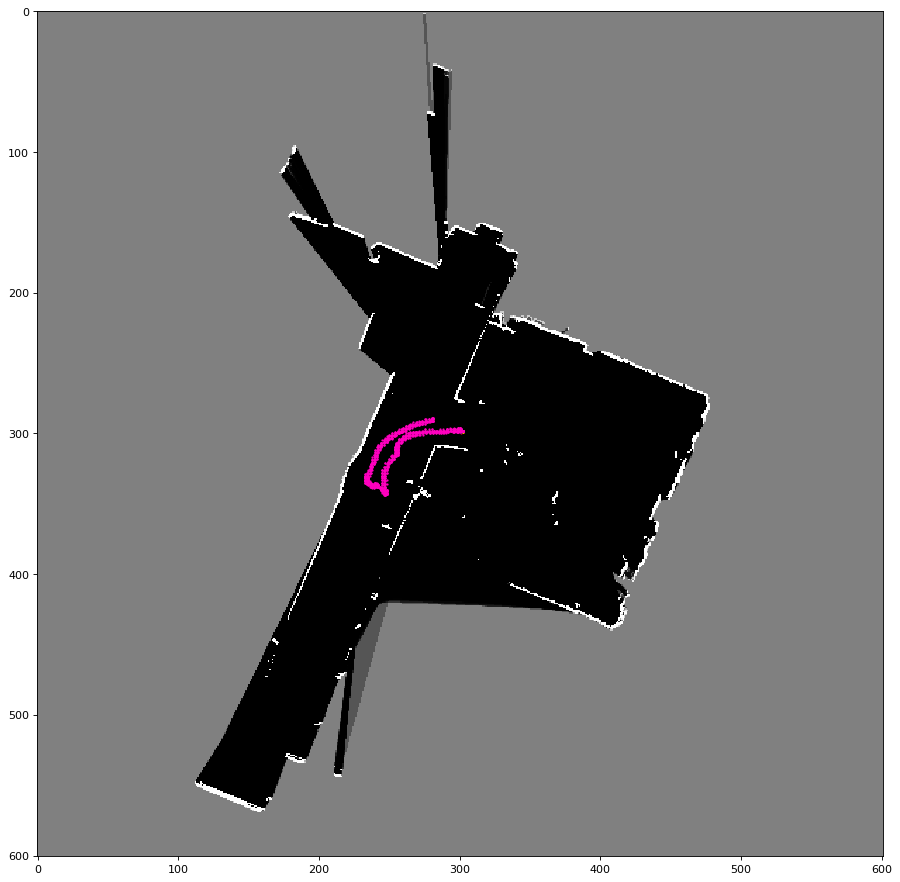

In [6]:
import pylab
indices = slam.coordinate_to_map_index(np.array(states))
plot_map(slam.map_prob, [indices[::5, 0], indices[::5, 1]], 20)

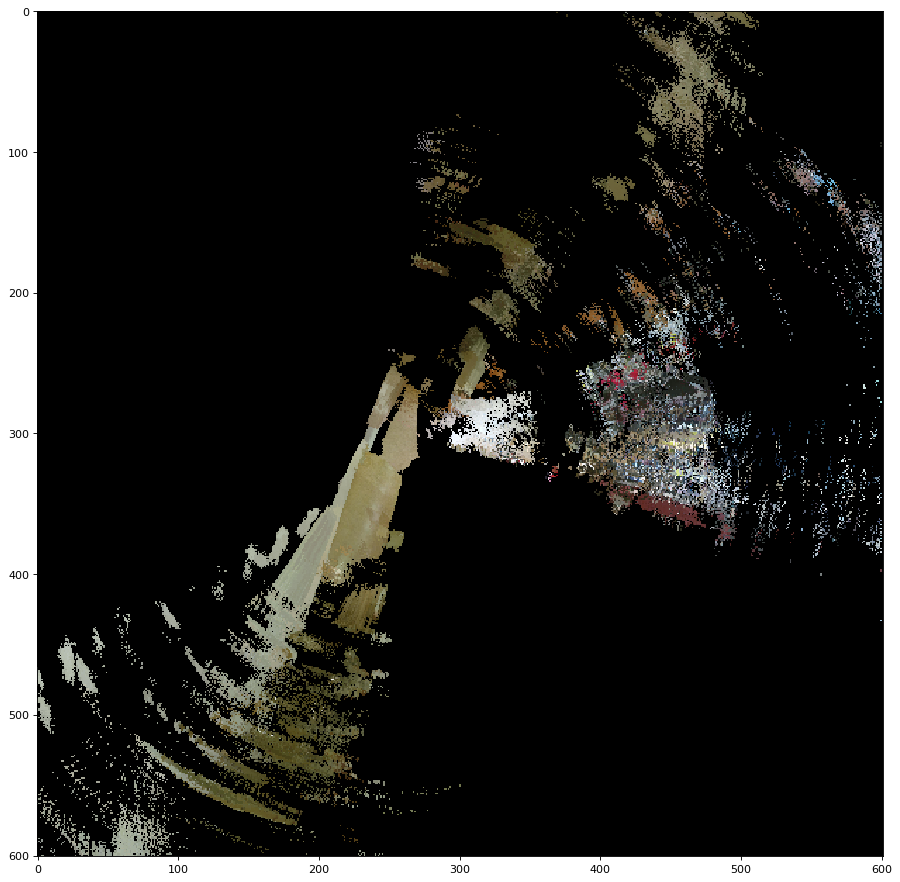

In [9]:
# fig = plt.figure(figsize=(8, 8))
# plt.imshow(slam.map_texture_raw)
# plt.show()
plot_map(slam.map_texture_raw)

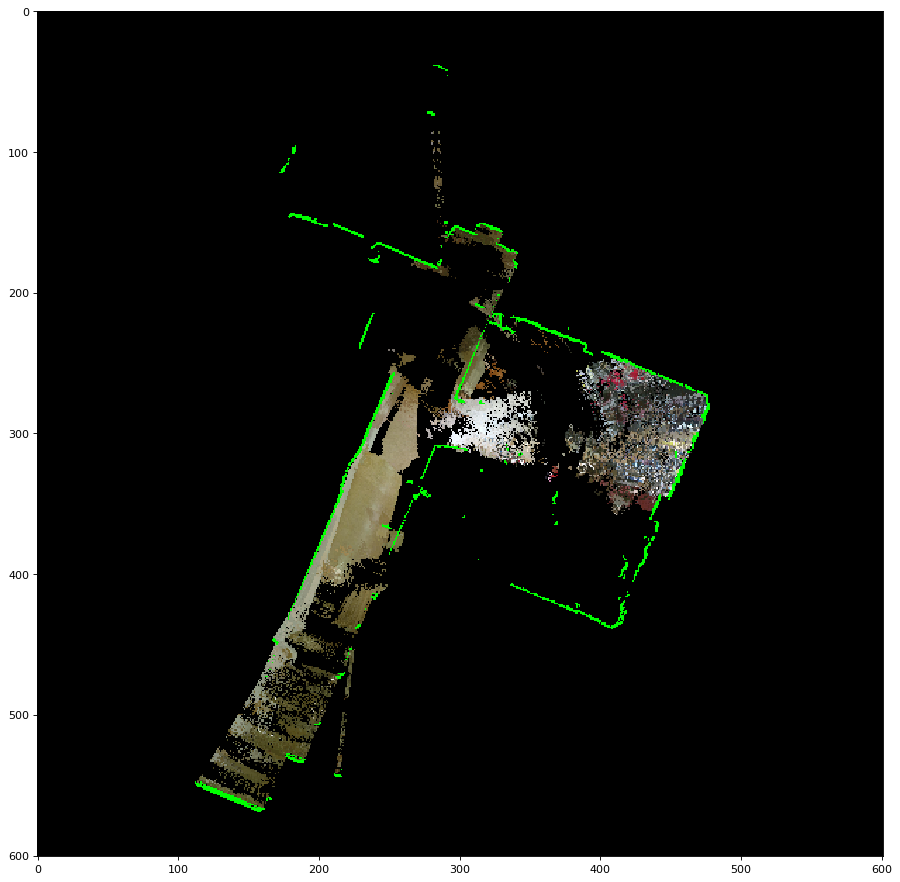

In [10]:
plot_map(slam.map_texture_trimmed)